In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
# # %pip install plotly
# import plotly.graph_objects as go
# import plotly.express as px
plt.style.use('classic')  # 'ggplot'
#sns.set_theme(style="whitegrid", palette="summer")
label_font_dict = {'family':"sans-serif", 'size':11, 'color':'black', 'style':'italic'}
title_font_dict = {'family':"sans-serif", 'size':13.5, 'color':'black', 'style':'italic'}

# %pip install missingno
import missingno as msno

from Clean_Function import benef_new_feats, benef_dummy_encode, annotation_with_hue, annotation_without_hue, annotation_index, in_out_null_values, in_new_feats, out_new_feats, benef_group_feats, provider_group_feats

 
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 100)

In [2]:
# Get the intergrated datasets
df_integrated = pd.read_csv("Data/df_integ.csv")

In [3]:
df_label = pd.read_csv("Data/Train-1542865627584.csv")

In [4]:
print(df_integrated.shape)
df_integrated.head()

(558211, 53)


BeneID   ClaimID  Provider  InscClaimAmtReimbursed AttendingPhysician  \
0  BENE11001  CLM46614  PRV55912                   26000          PHY390922   
1  BENE17521  CLM34721  PRV55912                   19000          PHY349293   
2  BENE21718  CLM72336  PRV55912                   17000          PHY334706   
3  BENE22934  CLM73394  PRV55912                   13000          PHY390614   
4  BENE24402  CLM32911  PRV55912                    3000          PHY380413   

  OperatingPhysician OtherPhysician ClmAdmitDiagnosisCode  DeductibleAmtPaid  \
0               None           None                  7866             1068.0   
1          PHY370861      PHY363291                 45340             1068.0   
2          PHY334706           None                 V5789             1068.0   
3          PHY323689      PHY363291                 71946             1068.0   
4          PHY432598           None                  1748             1068.0   

  DiagnosisGroupCode ClmDiagnosisCode_1 ClmDiagnosisCode_2 ClmDiagnosisCode_3  \
0                201               1970               4019               5853   
1                987               4240               2639               2948   
2                941              V5789               4168              73313   
3                506              71535              71960               4019   
4                593               2330               None               None   

  ClmDiagnosisCode_4 ClmDiagnosisCode_5 ClmDiagnosisCode_6 ClmDiagnosisCode_7  \
0               7843               2768              71590               2724   
1              40390              45821              28489               5854   
2               7812               7993              78830              72273   
3              V1202               4240               2449               2768   
4               None               None               None               None   

  ClmDiagnosisCode_8 ClmDiagnosisCode_9 ClmDiagnosisCode_10  \
0              19889               5849                None   
1               2753              E9305                None   
2              43812               4019                None   
3               None               None                None   
4               None               None                None   

  ClmProcedureCode_1 ClmProcedureCode_2 ClmProcedureCode_3  Claim_Duration  \
0               None               None               None               6   
1             7769.0             5849.0               None              12   
2             9338.0               None               None              18   
3             8154.0               None               None               4   
4             8543.0               None               None               4   

   Hospital_Duration  Claim_Start_Year  Claim_Start_Month  Total_Claim_Amt  \
0                6.0              2009                  4          27068.0   
1               12.0              2009                  1          20068.0   
2               18.0              2009                 10          18068.0   
3                4.0              2009                 10          14068.0   
4                4.0              2009                  1           4068.0   

   if_inpatient  Gender  Race  RenalDiseaseIndicator  State  County  \
0             1       1     1                      0     39     230   
1             1       0     1                      0     39     230   
2             1       1     1                      0     39     600   
3             1       0     1                      0     39     280   
4             1       0     2                      0     39     510   

   NoOfMonths_PartACov  NoOfMonths_PartBCov  ChronicCond_Alzheimer  \
0                   12                   12                      1   
1                   12                   12                      1   
2                   12                   12                      0   
3                   12                   12         

## Groupby columns to create new features by counting, summing, meaning values:

#### Group by Bene_ID

In [5]:
benef_group = benef_group_feats(df_integrated)
benef_group.head(2)

Bene_ID  if_inpatient  Claim_nunique  Provider_nunique  Att_nunique  \
0  BENE100000             0              2                 1            2   
1  BENE100001             0             10                 6           10   

   Op_nunique  Othr_nunique  Physician_nunique  
0           1             2                  5  
1           4             5                 19

#### Groupby State county columns to generate avery Reimbursed per State and County SC_Reimbursed_mean

In [6]:
SC_group = df_integrated[['State','County', 'InscClaimAmtReimbursed','if_inpatient']].groupby(['State','County','if_inpatient']).mean().round(2).reset_index()

SC_group.columns=['State','County','if_inpatient','SC_Reimbursed_mean']
SC_group.head()

State  County  if_inpatient  SC_Reimbursed_mean
0      1       0             0              204.71
1      1       0             1             5000.00
2      1      10             0              300.84
3      1      10             1             9178.57
4      1      20             0              420.59

In [7]:
df_integrated = df_integrated.merge(SC_group, how='left',on=['State','County','if_inpatient'])
df_integrated.head()

BeneID   ClaimID  Provider  InscClaimAmtReimbursed AttendingPhysician  \
0  BENE11001  CLM46614  PRV55912                   26000          PHY390922   
1  BENE17521  CLM34721  PRV55912                   19000          PHY349293   
2  BENE21718  CLM72336  PRV55912                   17000          PHY334706   
3  BENE22934  CLM73394  PRV55912                   13000          PHY390614   
4  BENE24402  CLM32911  PRV55912                    3000          PHY380413   

  OperatingPhysician OtherPhysician ClmAdmitDiagnosisCode  DeductibleAmtPaid  \
0               None           None                  7866             1068.0   
1          PHY370861      PHY363291                 45340             1068.0   
2          PHY334706           None                 V5789             1068.0   
3          PHY323689      PHY363291                 71946             1068.0   
4          PHY432598           None                  1748             1068.0   

  DiagnosisGroupCode ClmDiagnosisCode_1 ClmDiagnosisCode_2 ClmDiagnosisCode_3  \
0                201               1970               4019               5853   
1                987               4240               2639               2948   
2                941              V5789               4168              73313   
3                506              71535              71960               4019   
4                593               2330               None               None   

  ClmDiagnosisCode_4 ClmDiagnosisCode_5 ClmDiagnosisCode_6 ClmDiagnosisCode_7  \
0               7843               2768              71590               2724   
1              40390              45821              28489               5854   
2               7812               7993              78830              72273   
3              V1202               4240               2449               2768   
4               None               None               None               None   

  ClmDiagnosisCode_8 ClmDiagnosisCode_9 ClmDiagnosisCode_10  \
0              19889               5849                None   
1               2753              E9305                None   
2              43812               4019                None   
3               None               None                None   
4               None               None                None   

  ClmProcedureCode_1 ClmProcedureCode_2 ClmProcedureCode_3  Claim_Duration  \
0               None               None               None               6   
1             7769.0             5849.0               None              12   
2             9338.0               None               None              18   
3             8154.0               None               None               4   
4             8543.0               None               None               4   

   Hospital_Duration  Claim_Start_Year  Claim_Start_Month  Total_Claim_Amt  \
0                6.0              2009                  4          27068.0   
1               12.0              2009                  1          20068.0   
2               18.0              2009                 10          18068.0   
3                4.0              2009                 10          14068.0   
4                4.0              2009                  1           4068.0   

   if_inpatient  Gender  Race  RenalDiseaseIndicator  State  County  \
0             1       1     1                      0     39     230   
1             1       0     1                      0     39     230   
2             1       1     1                      0     39     600   
3             1       0     1                      0     39     280   
4             1       0     2                      0     39     510   

   NoOfMonths_PartACov  NoOfMonths_PartBCov  ChronicCond_Alzheimer  \
0                   12                   12                      1   
1                   12                   12                      1   
2                   12                   12                      0   
3                   12                   12         

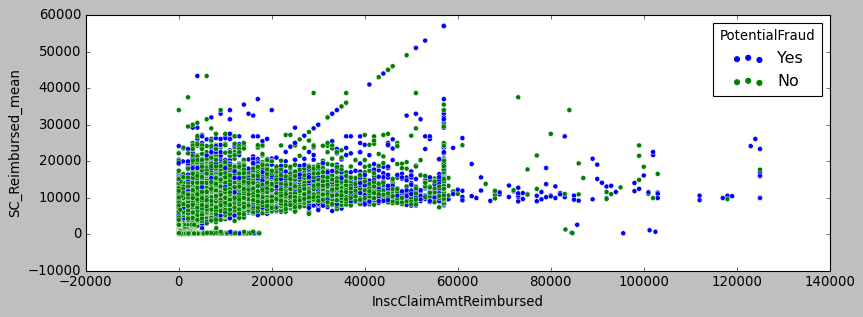

In [8]:
plt.figure(figsize=(12, 4))
sns.scatterplot(data=df_integrated, x='InscClaimAmtReimbursed',y='SC_Reimbursed_mean', hue='PotentialFraud')
plt.show()

In [9]:
df_integrated['diff_SC_Reimbursed']=df_integrated['InscClaimAmtReimbursed']-df_integrated['SC_Reimbursed_mean']

In [10]:
df_integrated.shape

(558211, 55)

#### Groupby provider if_inpatient column to generate new features: ,
'Bene_nunique', 'Claim_nunique', 'Att_nunique','Op_nunique','Othr_nunique',
'Diag_nunique','CD1','CD2','CD3', 'CD4','CD5','CD6','CD7', 'CD8','CD9','CD10','CP1','CP2','CP3',
'Claim_Duration_sum','Hospital_Duration_sum','Reimbursed_sum','Deductible_sum',
'SC_Reimbursed_sum','diff_SC_Reimbursed_sum','Age_sum','Risk_score_sum',
'Claim_Duration_max','Hospital_Duration_max','InscClaimAmtReimbursed_max','Risk_score_max'
'Physician_Cnt','Diag_Code_Cnt','Proc_Code_Cnt', 'Insurance_Covered_Per', 'Claim_Duration_mean','Hospital_Duration_mean','Reimbursed_mean','SC_Reimbursed_mean','diff_SC_Reimbursed_mean','Age_mean','Risk_score_mean'


In [11]:
provider_group = provider_group_feats(df_integrated)
print(provider_group.shape)
provider_group.head(2)

(7104, 47)


Provider  if_inpatient  Bene_nunique  Claim_nunique  Att_nunique  \
0  PRV51001             0            19             20           10   
1  PRV51001             1             5              5            4   

   Op_nunique  Othr_nunique  Diag_nunique  CD1  CD2  CD3  CD4  CD5  CD6  CD7  \
0           4             8             7   19   12    6    4    4    4    1   
1           3             2             5    5    5    5    5    5    5    4   

   CD8  CD9  CD10  CP1  CP2  CP3  Claim_Duration_mean  Claim_Duration_std  \
0    1    1     1    1    1    1                 0.55            2.012461   
1    3    2     1    3    2    1                 5.00            5.385165   

   Hospital_Duration_mean  Hospital_Duration_std  Reimbursed_mean  \
0                     0.0               0.000000            382.0   
1                     5.0               5.385165          19400.0   

   Reimbursed_std  Deductible_mean  Deductible_std  SC_Reimbursed_mean  \
0      422.817617              0.0             0.0            299.7025   
1    18352.111595           1068.0             0.0          20165.5460   

   SC_Reimbursed_std  diff_SC_Reimbursed_mean  diff_SC_Reimbursed_std  \
0          30.794253                  82.2975              419.930347   
1        9116.820061                -765.5460            20532.435414   

   Age_mean    Age_std  Risk_score_mean  Risk_score_std  Claim_Duration_max  \
0     78.95  12.584347             5.45        1.637553                   9   
1     78.40  10.644247             6.00        3.240370                  14   

   Hospital_Duration_max  Reimbursed_max  Deductible_max  Risk_score_max  \
0                    0.0            1500             0.0               9   
1                   14.0           42000          1068.0              10   

   Age_max  Physician_Cnt  Diag_Code_Cnt  Proc_Code_Cnt  Insurance_Covered_Per  
0       98             22             53              3                 100.00  
1       96              9             40              6                  94.78

In [12]:
provider_group_integrated = provider_group.merge(df_label, how='inner',left_on='Provider', right_on='Provider')
print(provider_group_integrated.shape)
provider_group_integrated.head(2)

(7104, 48)


Provider  if_inpatient  Bene_nunique  Claim_nunique  Att_nunique  \
0  PRV51001             0            19             20           10   
1  PRV51001             1             5              5            4   

   Op_nunique  Othr_nunique  Diag_nunique  CD1  CD2  CD3  CD4  CD5  CD6  CD7  \
0           4             8             7   19   12    6    4    4    4    1   
1           3             2             5    5    5    5    5    5    5    4   

   CD8  CD9  CD10  CP1  CP2  CP3  Claim_Duration_mean  Claim_Duration_std  \
0    1    1     1    1    1    1                 0.55            2.012461   
1    3    2     1    3    2    1                 5.00            5.385165   

   Hospital_Duration_mean  Hospital_Duration_std  Reimbursed_mean  \
0                     0.0               0.000000            382.0   
1                     5.0               5.385165          19400.0   

   Reimbursed_std  Deductible_mean  Deductible_std  SC_Reimbursed_mean  \
0      422.817617              0.0             0.0            299.7025   
1    18352.111595           1068.0             0.0          20165.5460   

   SC_Reimbursed_std  diff_SC_Reimbursed_mean  diff_SC_Reimbursed_std  \
0          30.794253                  82.2975              419.930347   
1        9116.820061                -765.5460            20532.435414   

   Age_mean    Age_std  Risk_score_mean  Risk_score_std  Claim_Duration_max  \
0     78.95  12.584347             5.45        1.637553                   9   
1     78.40  10.644247             6.00        3.240370                  14   

   Hospital_Duration_max  Reimbursed_max  Deductible_max  Risk_score_max  \
0                    0.0            1500             0.0               9   
1                   14.0           42000          1068.0              10   

   Age_max  Physician_Cnt  Diag_Code_Cnt  Proc_Code_Cnt  \
0       98             22             53              3   
1       96              9             40              6   

   Insurance_Covered_Per PotentialFraud  
0                 100.00             No  
1                  94.78             No

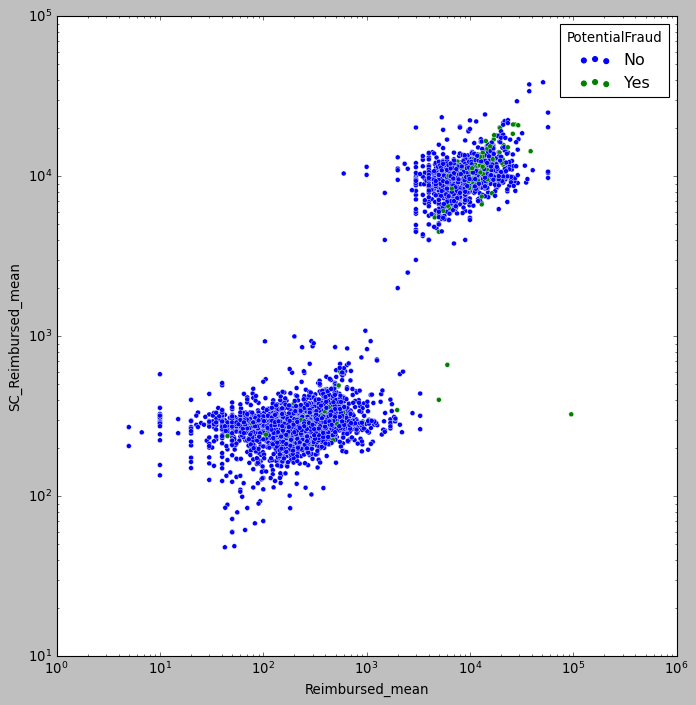

In [13]:
plt.figure(figsize=(10, 10))
sns.scatterplot(data=provider_group_integrated, x='Reimbursed_mean',y='SC_Reimbursed_mean', hue='PotentialFraud')
plt.xscale('log')
plt.yscale('log')
#plt.xlim([0, 100])
#plt.ylim([0, 600])
plt.show()

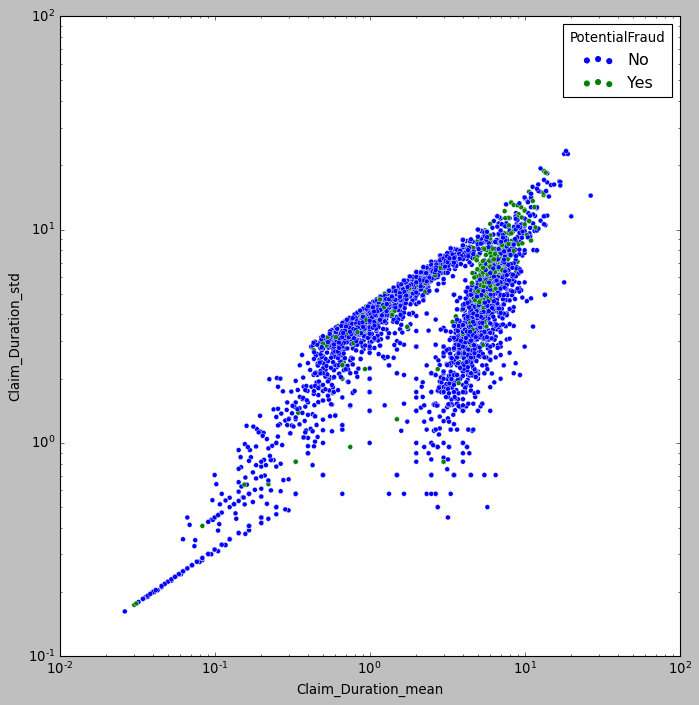

In [14]:
plt.figure(figsize=(10, 10))
sns.scatterplot(data=provider_group_integrated, x='Claim_Duration_mean',y='Claim_Duration_std', hue='PotentialFraud')
plt.xscale('log')
plt.yscale('log')
#plt.xlim([0, 100])
#plt.ylim([0, 600])
plt.show()

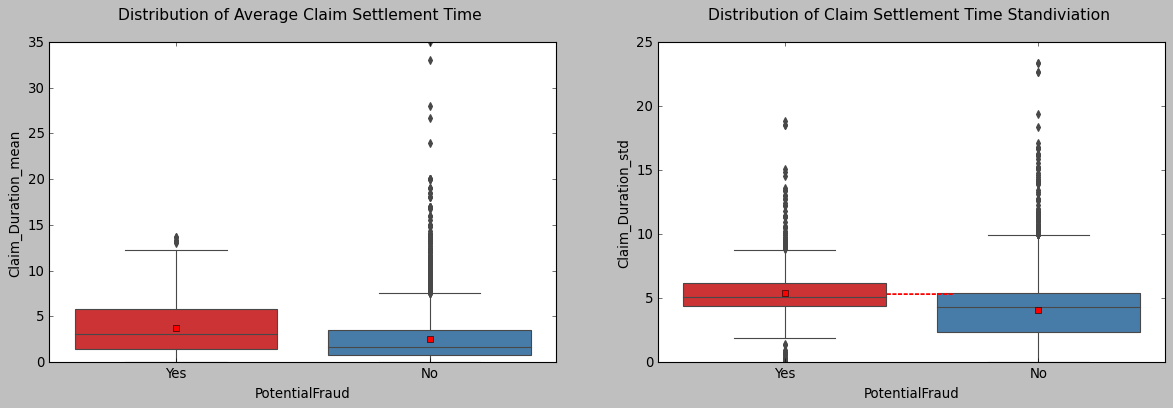

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(18, 5))
sns.boxplot(x="PotentialFraud", y="Claim_Duration_mean",data=provider_group_integrated, showmeans=True,palette="Set1",
                order=['Yes','No'],ax=axes[0])
axes[0].set_title("Distribution of Average Claim Settlement Time \n",fontsize = 14)

sns.boxplot(x="PotentialFraud", y="Claim_Duration_std",data=provider_group_integrated, showmeans=True,palette="Set1",
                order=['Yes','No'], ax=axes[1])
axes[1].set_title("Distribution of Claim Settlement Time Standiviation \n", fontsize = 14)
# add text annotation
axes[1].text(0.4, provider_group_integrated.Claim_Duration_std[provider_group_integrated['PotentialFraud']=='Yes'].median(), "------------ ", horizontalalignment='left', size='medium', color='red', weight='semibold')

plt.show()

In [16]:
provider_group_integrated.Claim_Duration_std[provider_group_integrated['PotentialFraud']=='Yes'].median()

5.064300390259552

In [17]:
provider_group_integrated.Claim_Duration_std[provider_group_integrated['PotentialFraud']=='No'].describe()

count    5791.000000
mean        4.056548
std         2.631760
min         0.000000
25%         2.380476
50%         4.298060
75%         5.406565
max        23.334524
Name: Claim_Duration_std, dtype: float64

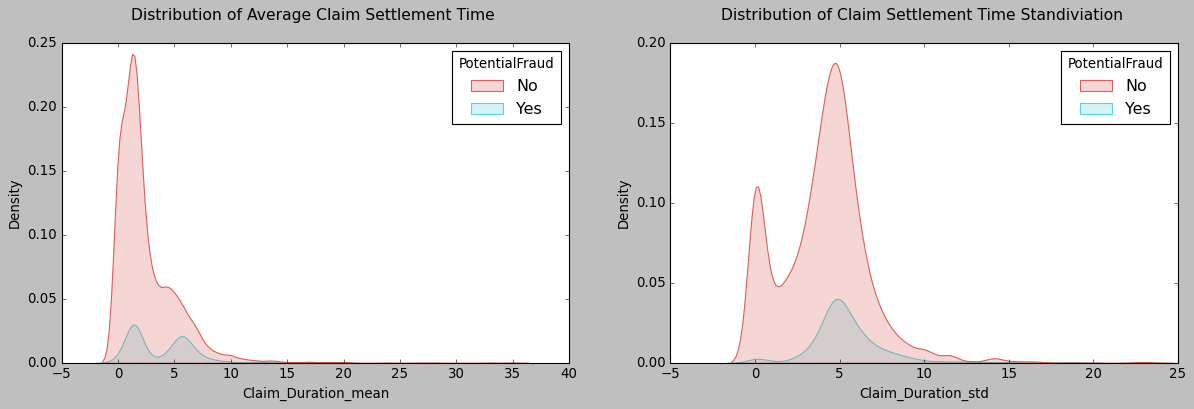

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(18, 5))
sns.kdeplot(hue="PotentialFraud", x="Claim_Duration_mean",data=provider_group_integrated, fill=True,  palette='hls',ax=axes[0])
axes[0].set_title("Distribution of Average Claim Settlement Time \n",fontsize = 14)

sns.kdeplot(hue="PotentialFraud", x="Claim_Duration_std",data=provider_group_integrated,fill=True,  palette='hls',ax=axes[1])
axes[1].set_title("Distribution of Claim Settlement Time Standiviation \n", fontsize = 14)

plt.show()

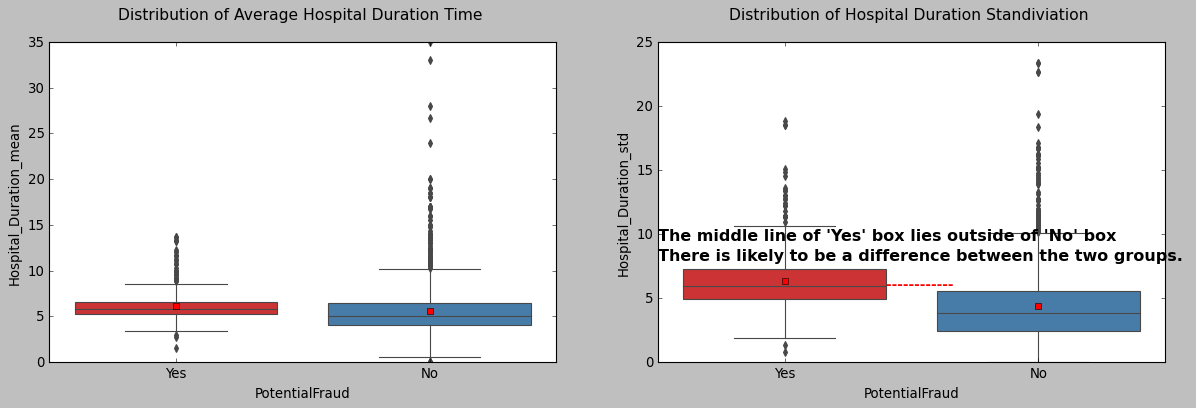

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(18, 5))
sns.boxplot(x="PotentialFraud", y="Hospital_Duration_mean",data=provider_group_integrated[provider_group_integrated['if_inpatient']==1], 
            showmeans=True,palette="Set1",order=['Yes','No'],ax=axes[0])
axes[0].set_title("Distribution of Average Hospital Duration Time \n",fontsize = 14)

sns.boxplot(x="PotentialFraud", y="Hospital_Duration_std",data=provider_group_integrated[provider_group_integrated['if_inpatient']==1], 
            showmeans=True,palette="Set1", order=['Yes','No'], ax=axes[1])
axes[1].set_title("Distribution of Hospital Duration Standiviation \n", fontsize = 14)

# add text annotation
axes[1].text(0.4, 5.8, "------------ ", horizontalalignment='left', size='medium', color='red', weight='semibold')
axes[1].text(-0.5, 9.5, "The middle line of 'Yes' box lies outside of 'No' box ", horizontalalignment='left', size='large', color='black', weight='semibold')
axes[1].text(-0.5, 8, "There is likely to be a difference between the two groups. ", horizontalalignment='left', size='large', color='black', weight='semibold')
plt.show()

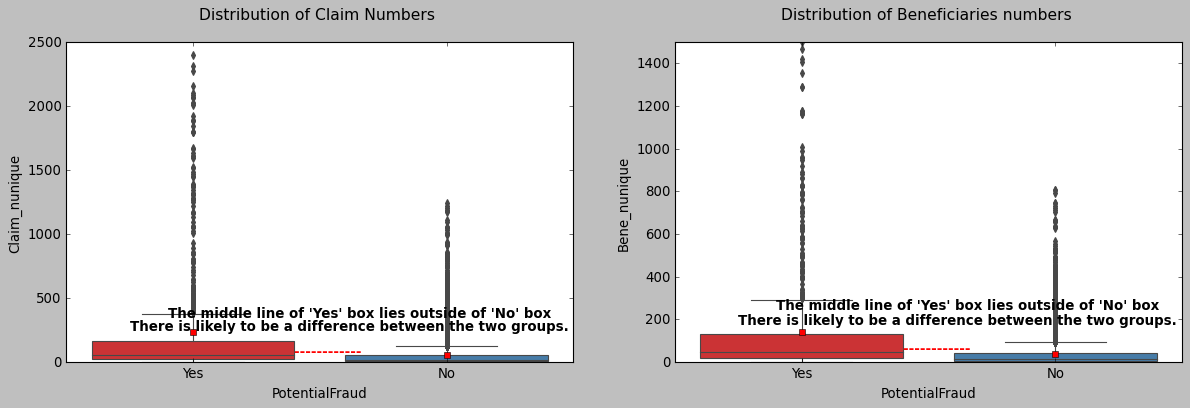

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(18, 5))
sns.boxplot(x="PotentialFraud", y="Claim_nunique",data=provider_group_integrated, showmeans=True,palette="Set1",
                order=['Yes','No'],ax=axes[0])
axes[0].set_title("Distribution of Claim Numbers \n",fontsize = 14)
axes[0].set_ylim([0, 2500])
axes[0].text(0.4, provider_group_integrated.Claim_nunique[provider_group_integrated['PotentialFraud']=='Yes'].median(), "------------ ", horizontalalignment='left', size='medium', color='red', weight='semibold')
axes[0].text(-0.1, 350, "The middle line of 'Yes' box lies outside of 'No' box ", horizontalalignment='left', size='medium', color='black', weight='semibold')
axes[0].text(-0.25, 250, "There is likely to be a difference between the two groups. ", horizontalalignment='left', size='medium', color='black', weight='semibold')
sns.boxplot(x="PotentialFraud", y="Bene_nunique",data=provider_group_integrated, showmeans=True,palette="Set1",
                order=['Yes','No'], ax=axes[1])
axes[1].set_title("Distribution of Beneficiaries numbers \n", fontsize = 14)
axes[1].set_ylim([0, 1500])
# add text annotation
axes[1].text(0.4, provider_group_integrated.Bene_nunique[provider_group_integrated['PotentialFraud']=='Yes'].median(), "------------ ", horizontalalignment='left', size='medium', color='red', weight='semibold')
axes[1].text(-0.1, 250, "The middle line of 'Yes' box lies outside of 'No' box ", horizontalalignment='left', size='medium', color='black', weight='semibold')
axes[1].text(-0.25, 180, "There is likely to be a difference between the two groups. ", horizontalalignment='left', size='medium', color='black', weight='semibold')
plt.show()

In [21]:
provider_group_integrated.Bene_nunique[provider_group_integrated['PotentialFraud']=='Yes'].median()

49.0

In [22]:
provider_group_integrated.Bene_nunique[provider_group_integrated['PotentialFraud']=='No'].describe()

count    6202.000000
mean       39.049984
std        73.093235
min         1.000000
25%         5.000000
50%        15.000000
75%        40.000000
max       807.000000
Name: Bene_nunique, dtype: float64

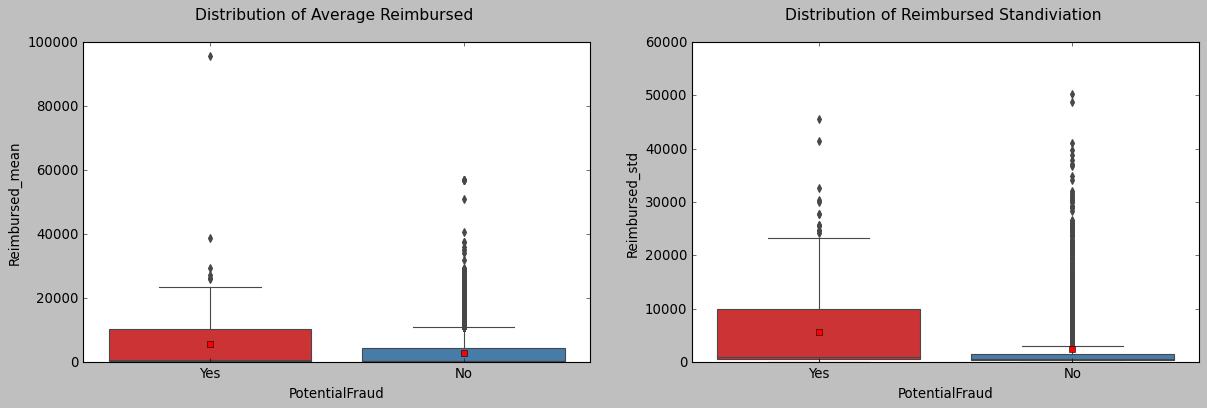

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(18, 5))
sns.boxplot(x="PotentialFraud", y="Reimbursed_mean",data=provider_group_integrated, showmeans=True,palette="Set1",
                order=['Yes','No'],ax=axes[0])
axes[0].set_title("Distribution of Average Reimbursed \n",fontsize = 14)

sns.boxplot(x="PotentialFraud", y="Reimbursed_std",data=provider_group_integrated, showmeans=True,palette="Set1",
                order=['Yes','No'], ax=axes[1])
axes[1].set_title("Distribution of Reimbursed Standiviation \n", fontsize = 14)

plt.show()

In [24]:
provider_group_integrated.Reimbursed_std[provider_group_integrated['PotentialFraud']=='Yes'].median()

1027.6791971927923

In [25]:
provider_group_integrated.Reimbursed_std[provider_group_integrated['PotentialFraud']=='No'].describe ()

count     5791.000000
mean      2439.322497
std       4510.653490
min          0.000000
25%        384.136407
50%        597.302218
75%       1449.714482
max      50204.581464
Name: Reimbursed_std, dtype: float64

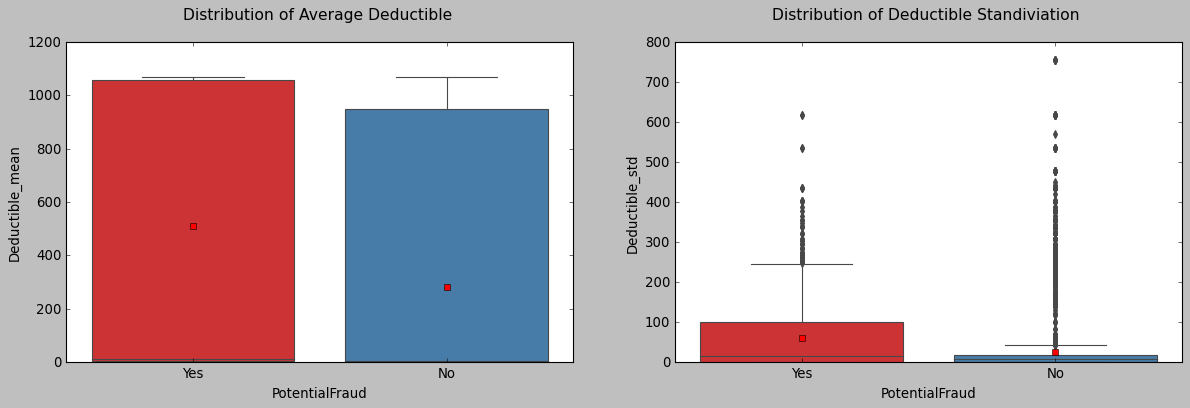

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(18, 5))
sns.boxplot(x="PotentialFraud", y="Deductible_mean",data=provider_group_integrated, showmeans=True,palette="Set1",
                order=['Yes','No'],ax=axes[0])
axes[0].set_title("Distribution of Average Deductible \n",fontsize = 14)

sns.boxplot(x="PotentialFraud", y="Deductible_std",data=provider_group_integrated, showmeans=True,palette="Set1",
                order=['Yes','No'], ax=axes[1])
axes[1].set_title("Distribution of Deductible Standiviation \n", fontsize = 14)

plt.show()

In [27]:
provider_group_integrated.Deductible_std[provider_group_integrated['PotentialFraud']=='Yes'].median()

14.622433397029225

In [28]:
provider_group_integrated.Deductible_std[provider_group_integrated['PotentialFraud']=='No'].describe ()

count    5791.000000
mean       24.353774
std        73.987877
min         0.000000
25%         0.000000
50%         7.184212
75%        16.780533
max       755.190042
Name: Deductible_std, dtype: float64

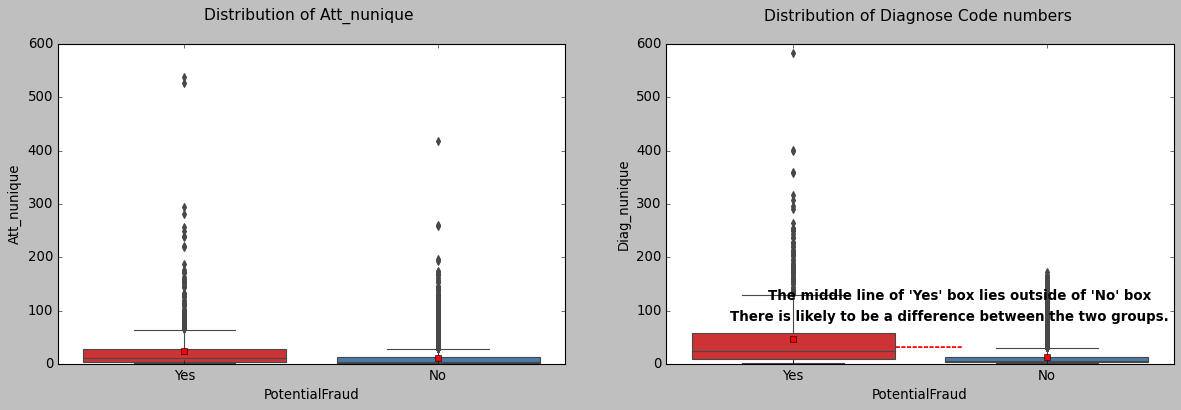

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(18, 5))
sns.boxplot(x="PotentialFraud", y="Att_nunique",data=provider_group_integrated, showmeans=True,palette="Set1",
                order=['Yes','No'],ax=axes[0])
axes[0].set_title("Distribution of Att_nunique \n",fontsize = 14)

sns.boxplot(x="PotentialFraud", y="Diag_nunique",data=provider_group_integrated, showmeans=True,palette="Set1",
                order=['Yes','No'], ax=axes[1])
axes[1].set_title("Distribution of Diagnose Code numbers \n", fontsize = 14)
axes[1].text(0.4, provider_group_integrated.Diag_nunique[provider_group_integrated['PotentialFraud']=='Yes'].median(), "------------ ", horizontalalignment='left', size='medium', color='red', weight='semibold')
axes[1].text(-0.1, 120, "The middle line of 'Yes' box lies outside of 'No' box ", horizontalalignment='left', size='medium', color='black', weight='semibold')
axes[1].text(-0.25, 80, "There is likely to be a difference between the two groups. ", horizontalalignment='left', size='medium', color='black', weight='semibold')

plt.show()

In [30]:
provider_group_integrated.Diag_nunique[provider_group_integrated['PotentialFraud']=='Yes'].median()

25.0

In [31]:
provider_group_integrated.Diag_nunique[provider_group_integrated['PotentialFraud']=='No'].describe ()

count    6202.000000
mean       12.493550
std        18.213255
min         1.000000
25%         3.000000
50%         6.000000
75%        14.000000
max       173.000000
Name: Diag_nunique, dtype: float64

In [32]:
provider_group_integrated.Att_nunique[provider_group_integrated['PotentialFraud']=='Yes'].median()

11.0

In [33]:
provider_group_integrated.Att_nunique[provider_group_integrated['PotentialFraud']=='No'].describe ()

count    6202.000000
mean       11.250242
std        19.255602
min         1.000000
25%         2.000000
50%         4.000000
75%        13.000000
max       419.000000
Name: Att_nunique, dtype: float64

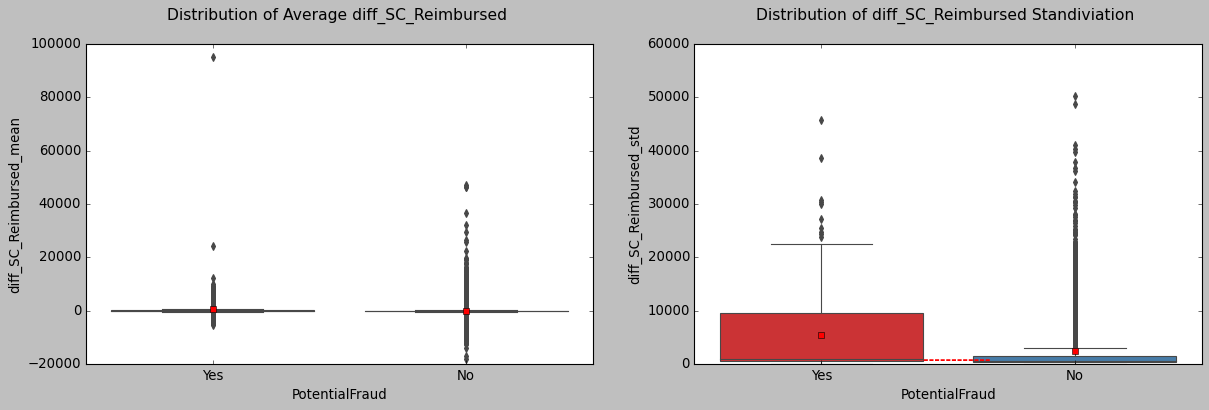

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(18, 5))
sns.boxplot(x="PotentialFraud", y="diff_SC_Reimbursed_mean",data=provider_group_integrated, showmeans=True,palette="Set1",
                order=['Yes','No'],ax=axes[0])
axes[0].set_title("Distribution of Average diff_SC_Reimbursed \n",fontsize = 14)

sns.boxplot(x="PotentialFraud", y="diff_SC_Reimbursed_std",data=provider_group_integrated, showmeans=True,palette="Set1",
                order=['Yes','No'], ax=axes[1])
axes[1].set_title("Distribution of diff_SC_Reimbursed Standiviation \n", fontsize = 14)
# add text annotation
axes[1].text(0.4, provider_group_integrated.diff_SC_Reimbursed_mean[provider_group_integrated['PotentialFraud']=='Yes'].median(), "------------ ", horizontalalignment='left', size='medium', color='red', weight='semibold')

plt.show()

In [35]:
provider_group_integrated.diff_SC_Reimbursed_mean[provider_group_integrated['PotentialFraud']=='Yes'].median()


-0.3504283154121829

In [36]:
provider_group_integrated.diff_SC_Reimbursed_mean[provider_group_integrated['PotentialFraud']=='No'].describe()

count     6202.000000
mean       -27.525533
std       2542.426278
min     -18030.306667
25%       -147.717143
50%        -21.008973
75%         59.629318
max      47237.500000
Name: diff_SC_Reimbursed_mean, dtype: float64

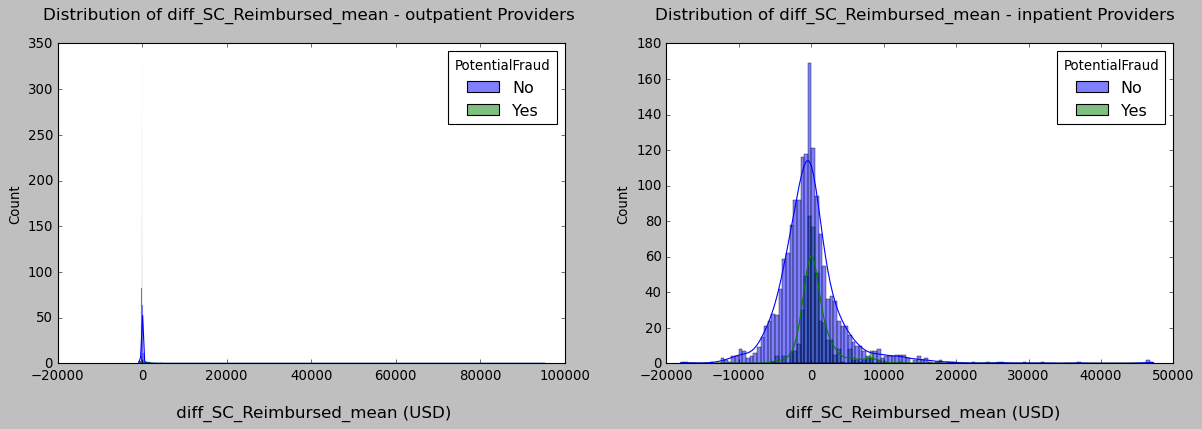

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

sns.histplot(data=provider_group_integrated[provider_group_integrated['if_inpatient']==0], 
             x='diff_SC_Reimbursed_mean',kde=True, hue='PotentialFraud',ax=axes[0]) 
axes[0].set_title("Distribution of diff_SC_Reimbursed_mean - outpatient Providers \n",fontsize = 15)
axes[0].set_xlabel("\n diff_SC_Reimbursed_mean (USD)", fontsize = 15)

sns.histplot(data=provider_group_integrated[provider_group_integrated['if_inpatient']==1],  x='diff_SC_Reimbursed_mean',
             kde=True,hue='PotentialFraud', ax=axes[1]) 
axes[1].set_title("Distribution of diff_SC_Reimbursed_mean - inpatient Providers  \n",fontsize = 15)
axes[1].set_xlabel("\n diff_SC_Reimbursed_mean (USD)", fontsize = 15)

plt.show()

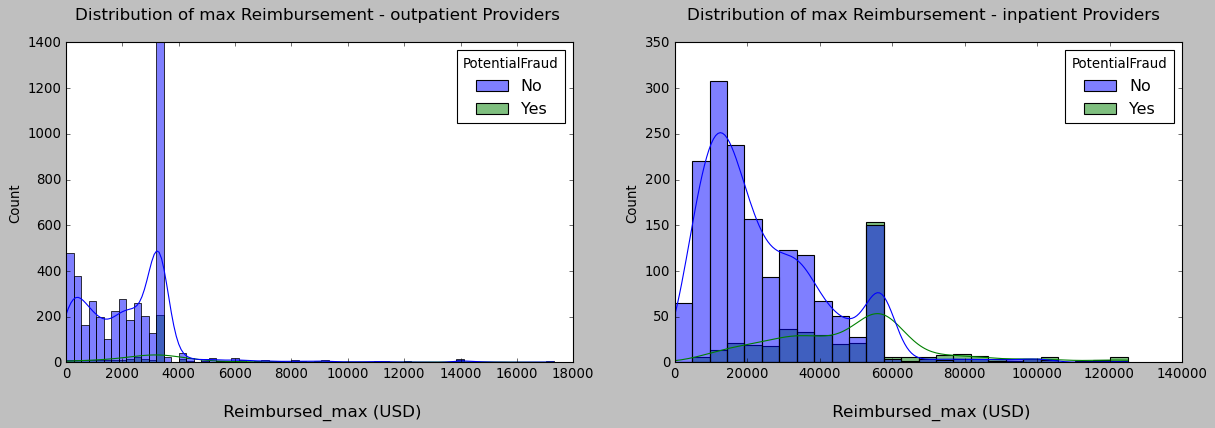

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

sns.histplot(data=provider_group_integrated[(provider_group_integrated['if_inpatient']==0)&(provider_group_integrated.Reimbursed_max<=20000)], 
             x='Reimbursed_max',kde=True, hue='PotentialFraud',ax=axes[0]) 
axes[0].set_title("Distribution of max Reimbursement - outpatient Providers \n",fontsize = 15)
axes[0].set_xlabel("\n Reimbursed_max (USD)", fontsize = 15)

sns.histplot(data=provider_group_integrated[provider_group_integrated['if_inpatient']==1],  x='Reimbursed_max',
             kde=True,hue='PotentialFraud', ax=axes[1]) 
axes[1].set_title("Distribution of max Reimbursement - inpatient Providers  \n",fontsize = 15)
axes[1].set_xlabel("\n Reimbursed_max (USD)", fontsize = 15)

plt.show()

<Figure size 1440x400 with 0 Axes>

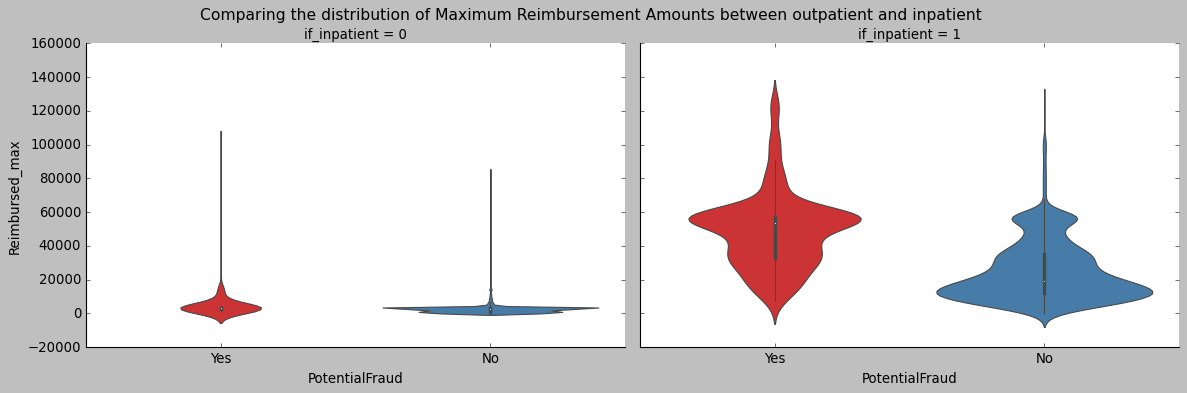

In [39]:
plt.figure(figsize = (18,5))
cat = sns.catplot(x="PotentialFraud", y="Reimbursed_max", col="if_inpatient", data=provider_group_integrated, palette="Set1",
                order=['Yes','No'], height=5, aspect=1.5,  kind="violin")
cat.fig.subplots_adjust(top=0.89)
cat.fig.suptitle("Comparing the distribution of Maximum Reimbursement Amounts between outpatient and inpatient \n", fontsize = 14)
plt.show()

In [40]:
provider_reimmax=provider_group_integrated[['Provider','if_inpatient','Reimbursed_max','PotentialFraud']].sort_values(by='Reimbursed_max',ascending=False)
provider_reimmax.head()

Provider  if_inpatient  Reimbursed_max PotentialFraud
2700  PRV53461             1          125000            Yes
2006  PRV52815             1          125000            Yes
5339  PRV56044             1          125000             No
4427  PRV55172             1          125000            Yes
3979  PRV54742             1          125000            Yes

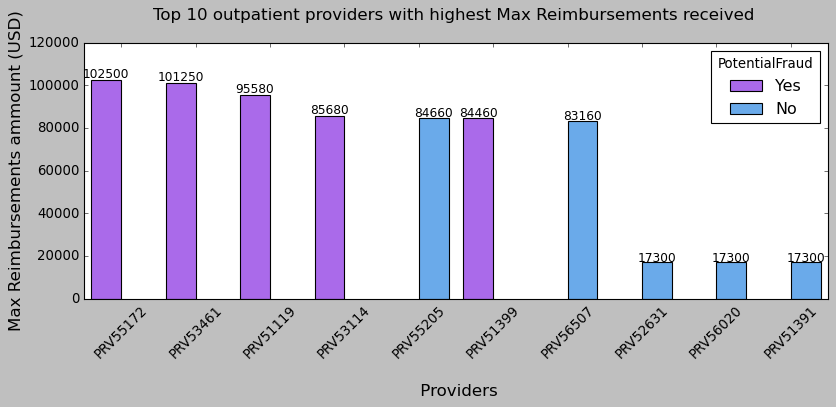

In [41]:
plt.figure(figsize=(12, 4))
top10_outpatient = provider_reimmax[provider_reimmax['if_inpatient']==0].head(10)
fig = sns.barplot(data=top10_outpatient, x='Provider', y='Reimbursed_max', hue='PotentialFraud', palette='cool_r')
# Grouped bar chart with labels
for p in fig.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    fig.annotate('{:.0f}'.format(height), (x+width/2,y+height*1.01), 
                 ha='center', fontsize=11)
# fig.bar_label(fig.containers[0], size=12) # bar chart with labels
plt.xticks(rotation=45)   
plt.xlabel("\n Providers", fontsize = 15)
plt.ylabel("Max Reimbursements ammount (USD)", fontsize = 15)
plt.title("Top 10 outpatient providers with highest Max Reimbursements received \n", fontsize = 15)
plt.show()

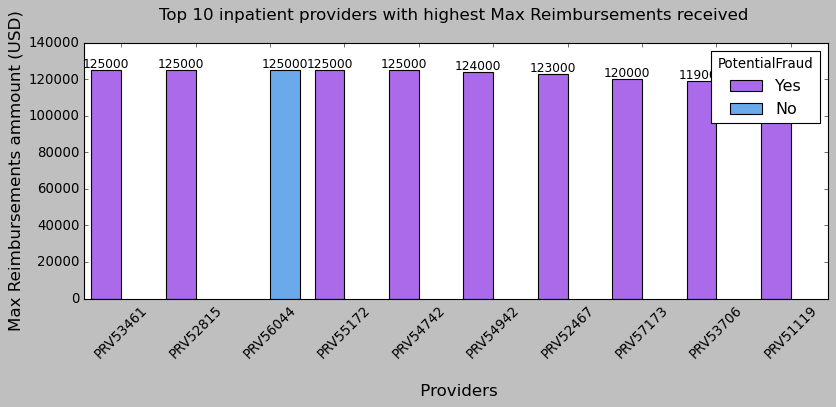

In [42]:
plt.figure(figsize=(12, 4))
top10_inpatient = provider_reimmax[provider_reimmax['if_inpatient']==1].head(10)
fig = sns.barplot(data=top10_inpatient, x='Provider', y='Reimbursed_max', hue='PotentialFraud', palette='cool_r')
# Grouped bar chart with labels
for p in fig.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    fig.annotate('{:.0f}'.format(height), (x+width/2,y+height*1.01), 
                 ha='center', fontsize=11)
# fig.bar_label(fig.containers[0], size=12) # bar chart with labels
plt.xticks(rotation=45)   
plt.xlabel("\n Providers", fontsize = 15)
plt.ylabel("Max Reimbursements ammount (USD)", fontsize = 15)
plt.title("Top 10 inpatient providers with highest Max Reimbursements received \n", fontsize = 15)
plt.show()

<Figure size 1440x400 with 0 Axes>

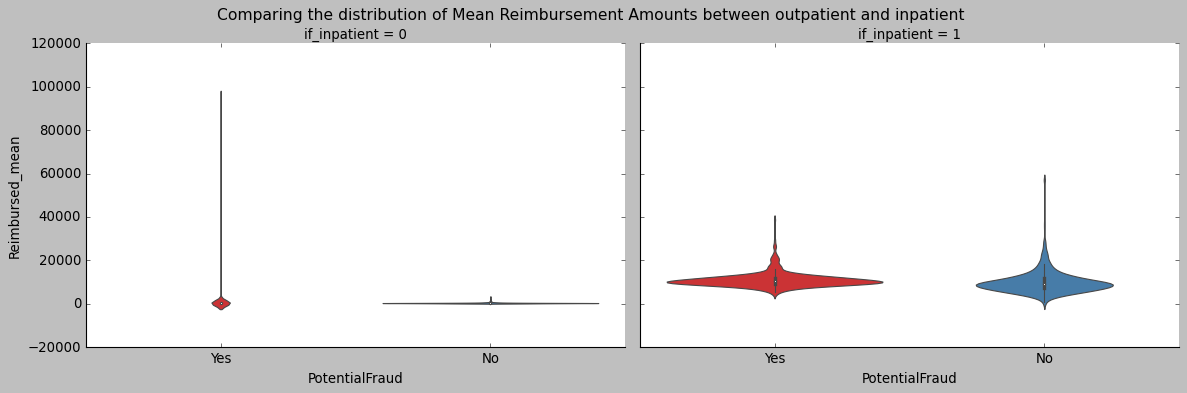

In [43]:
plt.figure(figsize = (18,5))
cat = sns.catplot(x="PotentialFraud", y="Reimbursed_mean", col="if_inpatient", data=provider_group_integrated, palette="Set1",
                order=['Yes','No'], height=5, aspect=1.5,  kind="violin")
cat.fig.subplots_adjust(top=0.89)
cat.fig.suptitle("Comparing the distribution of Mean Reimbursement Amounts between outpatient and inpatient \n", fontsize = 14)
plt.show()

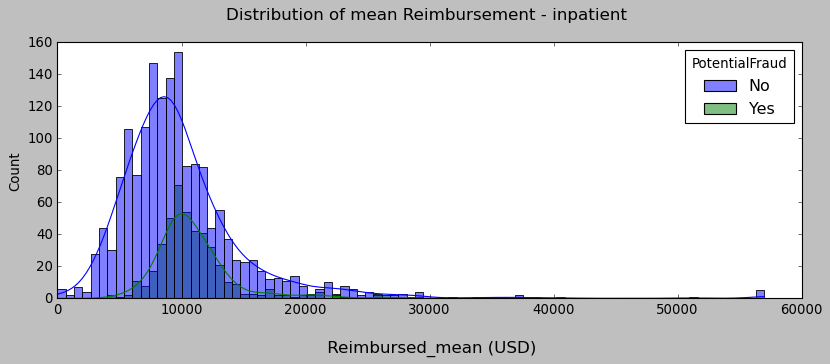

In [44]:
plt.figure(figsize=(12, 4))

sns.histplot(data=provider_group_integrated[provider_group_integrated['if_inpatient']==1], x='Reimbursed_mean',kde=True, hue='PotentialFraud') 
plt.title("Distribution of mean Reimbursement - inpatient \n",fontsize = 15)
plt.xlabel("\n Reimbursed_mean (USD)", fontsize = 15)

plt.show()

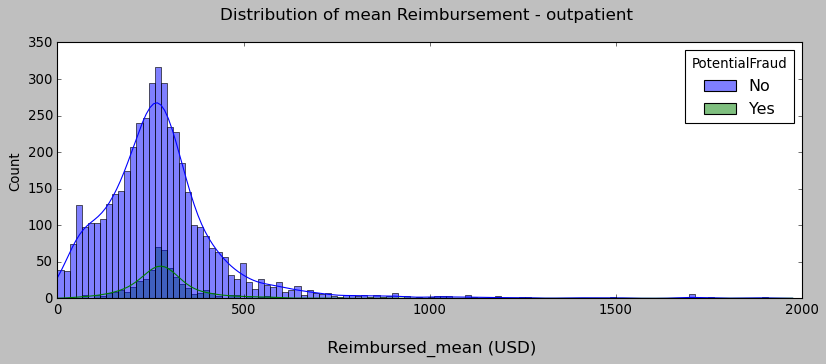

In [45]:
plt.figure(figsize=(12, 4))

sns.histplot(data=provider_group_integrated[(provider_group_integrated['if_inpatient']==0)&(provider_group_integrated.Reimbursed_mean <= 2000)], x='Reimbursed_mean',kde=True, hue='PotentialFraud') 
plt.title("Distribution of mean Reimbursement - outpatient \n",fontsize = 15)
plt.xlabel("\n Reimbursed_mean (USD)", fontsize = 15)
plt.show()

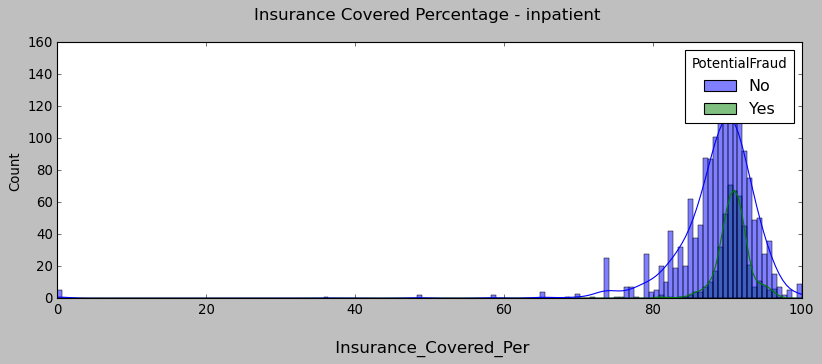

In [46]:
plt.figure(figsize=(12, 4))

sns.histplot(data=provider_group_integrated[provider_group_integrated['if_inpatient']==1], x='Insurance_Covered_Per',kde=True, hue='PotentialFraud') 
plt.title("Insurance Covered Percentage - inpatient \n",fontsize = 15)
plt.xlabel("\n Insurance_Covered_Per", fontsize = 15)
plt.show()

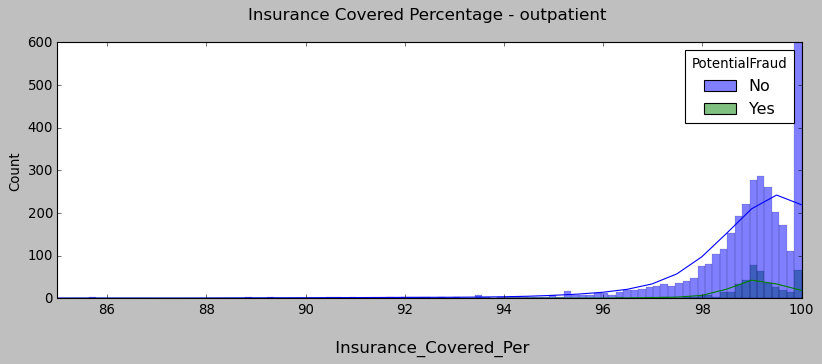

In [47]:
plt.figure(figsize=(12, 4))

sns.histplot(data=provider_group_integrated[provider_group_integrated['if_inpatient']==0], x='Insurance_Covered_Per',kde=True, hue='PotentialFraud') 
plt.title("Insurance Covered Percentage - outpatient \n",fontsize = 15)
plt.xlabel("\n Insurance_Covered_Per", fontsize = 15)
plt.xlim([85, 100])
plt.ylim([0, 600])
plt.show()

### Observe the number of claims submitted by inpatient and oupatient providers, and compare fraud and non-fraud transcations.

<Figure size 1440x400 with 0 Axes>

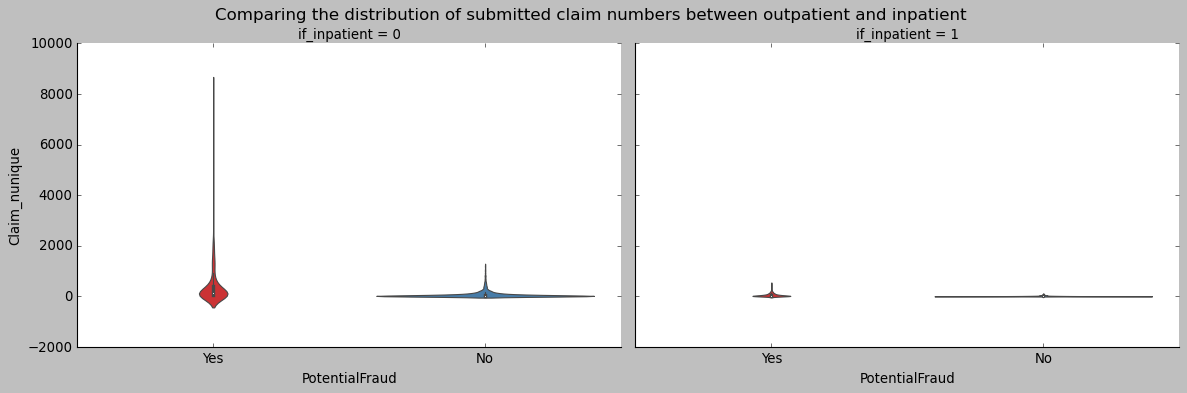

In [48]:
plt.figure(figsize = (18,5))
cat = sns.catplot(x="PotentialFraud", y="Claim_nunique", col="if_inpatient", data=provider_group_integrated, palette="Set1",
                order=['Yes','No'], height=5, aspect=1.5,  kind="violin")
cat.fig.subplots_adjust(top=0.89)
cat.fig.suptitle("Comparing the distribution of submitted claim numbers between outpatient and inpatient \n", fontsize = 15)
plt.show()

In [49]:
provider_nclaim=provider_group_integrated[['Provider','if_inpatient','Claim_nunique','PotentialFraud']].sort_values(by='Claim_nunique',ascending=False)
provider_nclaim.head()

Provider  if_inpatient  Claim_nunique PotentialFraud
536   PRV51459             0           8240            Yes
3023  PRV53797             0           4739            Yes
683   PRV51574             0           4444            Yes
3127  PRV53918             0           3588            Yes
4133  PRV54895             0           3433            Yes

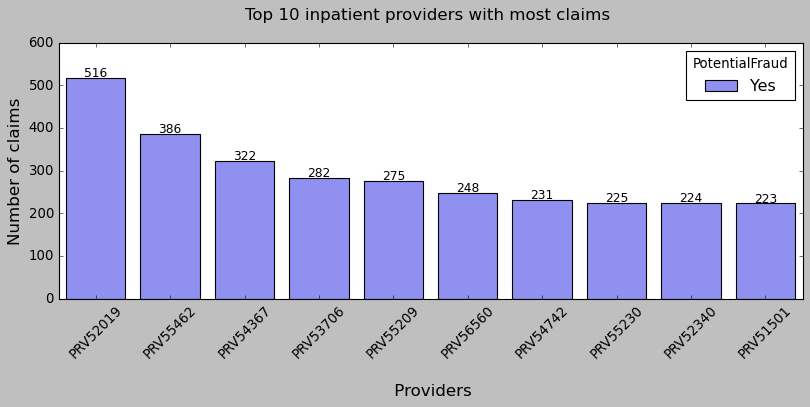

In [50]:
plt.figure(figsize=(12, 4))
top10_inpatient = provider_nclaim[provider_nclaim['if_inpatient']==1].head(10)
fig = sns.barplot(data=top10_inpatient, x='Provider', y='Claim_nunique', hue='PotentialFraud', palette='cool_r')
# Grouped bar chart with labels
for p in fig.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    fig.annotate('{:.0f}'.format(height), (x+width/2,y+height*1.01), 
                 ha='center', fontsize=11)
# fig.bar_label(fig.containers[0], size=12) # bar chart with labels
plt.xticks(rotation=45)   
plt.xlabel("\n Providers", fontsize = 15)
plt.ylabel("Number of claims", fontsize = 15)
plt.title("Top 10 inpatient providers with most claims \n", fontsize = 15)
plt.show()

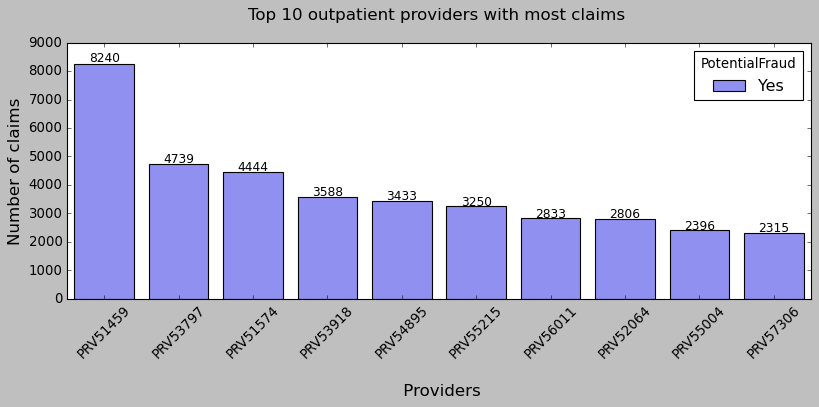

In [51]:
plt.figure(figsize=(12, 4))
top10_outpatient = provider_nclaim[provider_nclaim['if_inpatient']==0].head(10)
fig = sns.barplot(data=top10_outpatient, x='Provider', y='Claim_nunique', hue='PotentialFraud', palette='cool_r')
# Grouped bar chart with labels
for p in fig.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    fig.annotate('{:.0f}'.format(height), (x+width/2,y+height*1.01), 
                 ha='center', fontsize=11)
# fig.bar_label(fig.containers[0], size=12) # bar chart with labels
plt.xticks(rotation=45)   
plt.xlabel("\n Providers", fontsize = 15)
plt.ylabel("Number of claims", fontsize = 15)
plt.title("Top 10 outpatient providers with most claims \n", fontsize = 15)
plt.show()

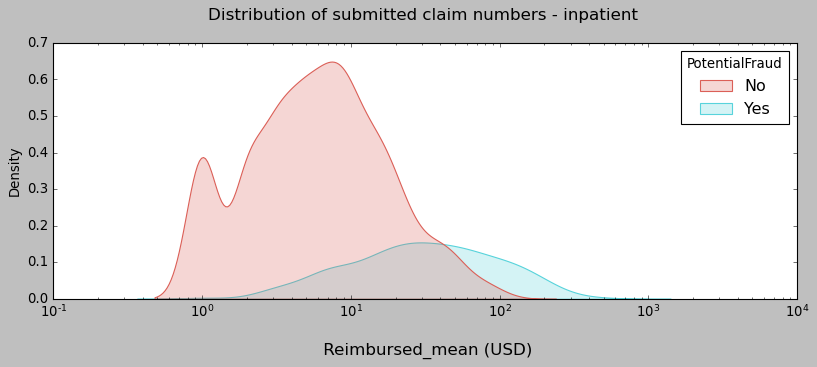

In [52]:
plt.figure(figsize=(12, 4))
sns.kdeplot(data=provider_group_integrated[provider_group_integrated['if_inpatient']==1], x='Claim_nunique', hue="PotentialFraud", fill=True, log_scale=True, palette='hls')
#sns.histplot(data=provider_group_integrated[provider_group_integrated['if_inpatient']==1], x='Claim_nunique',kde=True, hue='PotentialFraud') 
plt.title("Distribution of submitted claim numbers - inpatient \n",fontsize = 15)
plt.xlabel("\n Reimbursed_mean (USD)", fontsize = 15)
plt.show()

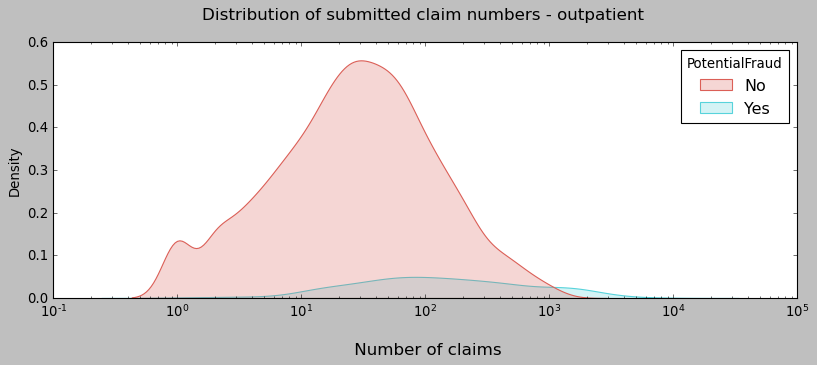

In [53]:
plt.figure(figsize=(12, 4))
sns.kdeplot(data=provider_group_integrated[provider_group_integrated['if_inpatient']==0], x='Claim_nunique', hue="PotentialFraud", fill=True, log_scale=True, palette='hls')
#sns.histplot(data=provider_group_integrated[provider_group_integrated['if_inpatient']==0], x='Claim_nunique',kde=True, hue='PotentialFraud') 
plt.title("Distribution of submitted claim numbers - outpatient \n",fontsize = 15)
plt.xlabel("\n Number of claims", fontsize = 15)
plt.show()

### Observe the number of physicans affiliated with  inpatient and oupatient providers, and compare fraud and non-fraud transcations.

In [54]:
provider_nphysician=provider_group_integrated[['Provider','if_inpatient','Physician_Cnt','PotentialFraud']].sort_values(by='Physician_Cnt',ascending=False)
provider_nphysician.head()

Provider  if_inpatient  Physician_Cnt PotentialFraud
4485  PRV55215             0           1285            Yes
4776  PRV55510             0            797             No
1151  PRV52019             0            795            Yes
6488  PRV57173             0            672            Yes
3287  PRV54070             0            578            Yes

<Figure size 1440x400 with 0 Axes>

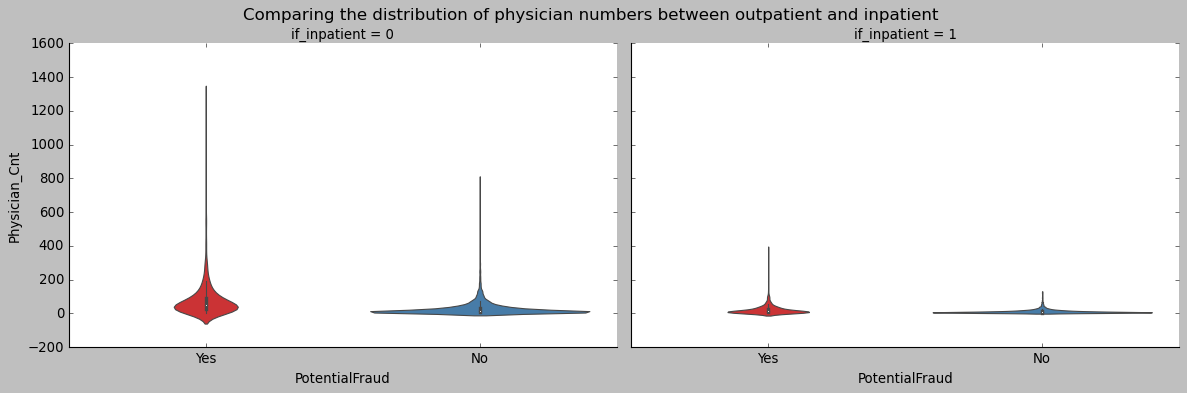

In [55]:
plt.figure(figsize = (18,5))
cat = sns.catplot(x="PotentialFraud", y="Physician_Cnt", col="if_inpatient", data=provider_group_integrated, palette="Set1",
                order=['Yes','No'], height=5, aspect=1.5,  kind="violin")
cat.fig.subplots_adjust(top=0.89)
cat.fig.suptitle("Comparing the distribution of physician numbers between outpatient and inpatient \n", fontsize = 15)
plt.show()

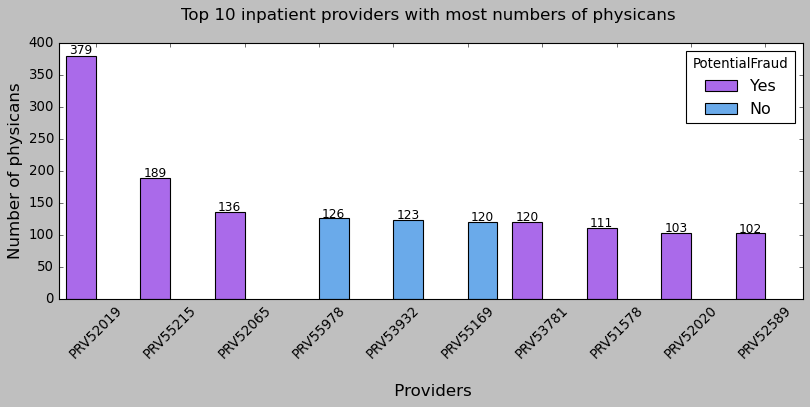

In [56]:
plt.figure(figsize=(12, 4))
top10_inpatient_nphysician = provider_nphysician[provider_nphysician['if_inpatient']==1].head(10)
fig = sns.barplot(data=top10_inpatient_nphysician, x='Provider', y='Physician_Cnt', hue='PotentialFraud', palette='cool_r')
# Grouped bar chart with labels
for p in fig.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    fig.annotate('{:.0f}'.format(height), (x+width/2,y+height*1.01), 
                 ha='center', fontsize=11)
# fig.bar_label(fig.containers[0], size=12) # bar chart with labels
plt.xticks(rotation=45)   
plt.xlabel("\n Providers", fontsize = 15)
plt.ylabel("Number of physicans", fontsize = 15)
plt.title("Top 10 inpatient providers with most numbers of physicans \n", fontsize = 15)
plt.show()

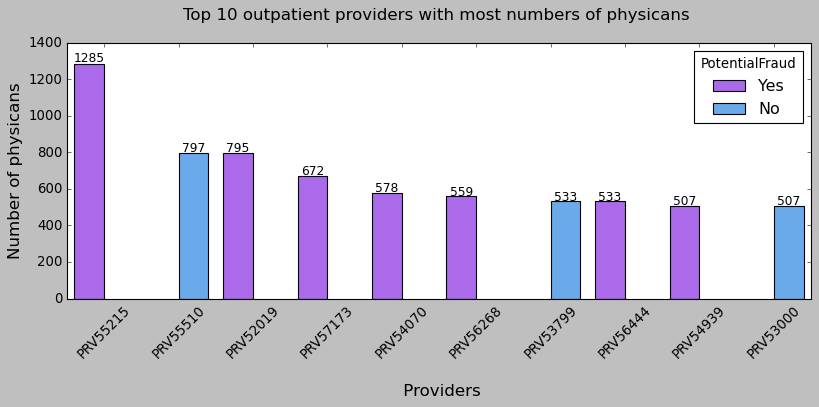

In [57]:
plt.figure(figsize=(12, 4))
top10_outpatient_nphysician = provider_nphysician[provider_nphysician['if_inpatient']==0].head(10)
fig = sns.barplot(data=top10_outpatient_nphysician, x='Provider', y='Physician_Cnt', hue='PotentialFraud', palette='cool_r')
# Grouped bar chart with labels
for p in fig.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    fig.annotate('{:.0f}'.format(height), (x+width/2,y+height*1.01), 
                 ha='center', fontsize=11)
# fig.bar_label(fig.containers[0], size=12) # bar chart with labels
plt.xticks(rotation=45)   
plt.xlabel("\n Providers", fontsize = 15)
plt.ylabel("Number of physicans", fontsize = 15)
plt.title("Top 10 outpatient providers with most numbers of physicans \n", fontsize = 15)
plt.show()

### Observe the number of diagnose codes submitted by inpatient and oupatient providers, and compare potiential fraud and non-fraud transcations.

<Figure size 1440x400 with 0 Axes>

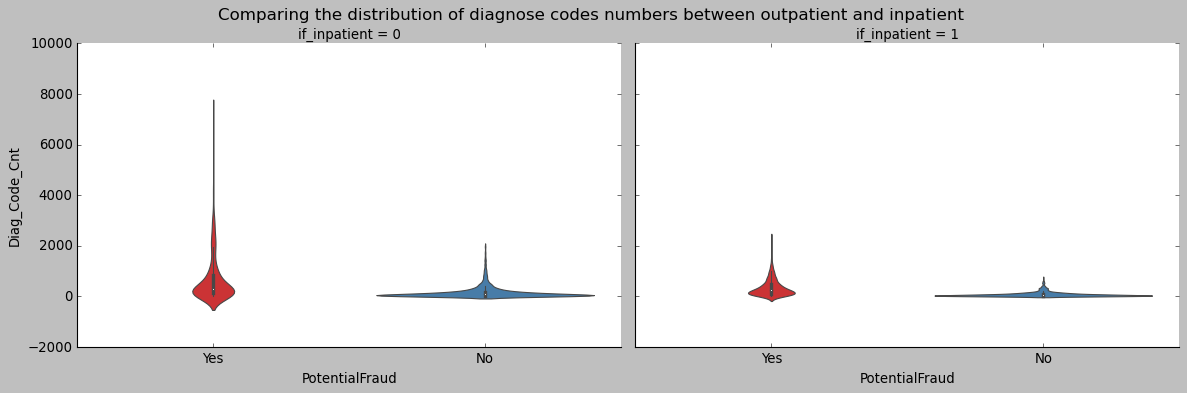

In [58]:
plt.figure(figsize = (18,5))
cat = sns.catplot(x="PotentialFraud", y="Diag_Code_Cnt", col="if_inpatient", data=provider_group_integrated, palette="Set1",
                order=['Yes','No'], height=5, aspect=1.5,  kind="violin")
cat.fig.subplots_adjust(top=0.89)
cat.fig.suptitle("Comparing the distribution of diagnose codes numbers between outpatient and inpatient \n", fontsize = 15)
plt.show()

In [59]:
provider_ndiagcode=provider_group_integrated[['Provider','if_inpatient','Diag_Code_Cnt','PotentialFraud']].sort_values(by='Diag_Code_Cnt',ascending=False)
provider_ndiagcode.head()

Provider  if_inpatient  Diag_Code_Cnt PotentialFraud
536   PRV51459             0           7234            Yes
3023  PRV53797             0           5197            Yes
683   PRV51574             0           4990            Yes
3127  PRV53918             0           4285            Yes
4485  PRV55215             0           4187            Yes

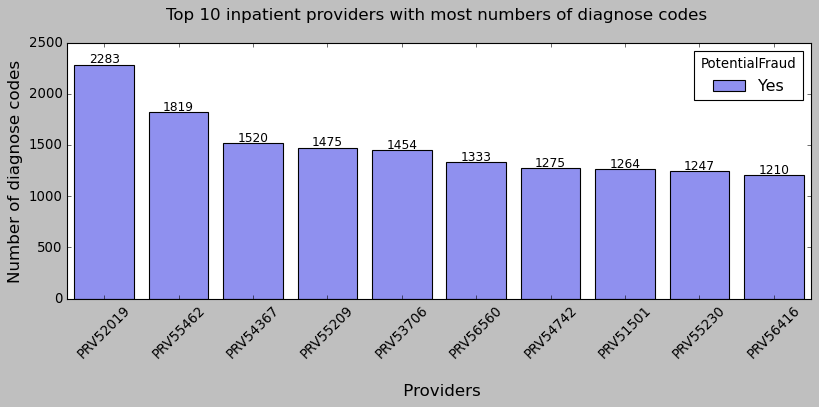

In [60]:
plt.figure(figsize=(12, 4))
top10_inpatient_ndiagcode = provider_ndiagcode[provider_ndiagcode['if_inpatient']==1].head(10)
fig = sns.barplot(data=top10_inpatient_ndiagcode, x='Provider', y='Diag_Code_Cnt', hue='PotentialFraud', palette='cool_r')
# Grouped bar chart with labels
for p in fig.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    fig.annotate('{:.0f}'.format(height), (x+width/2,y+height*1.01), 
                 ha='center', fontsize=11)
# fig.bar_label(fig.containers[0], size=12) # bar chart with labels
plt.xticks(rotation=45)   
plt.xlabel("\n Providers", fontsize = 15)
plt.ylabel("Number of diagnose codes", fontsize = 15)
plt.title("Top 10 inpatient providers with most numbers of diagnose codes \n", fontsize = 15)
plt.show()

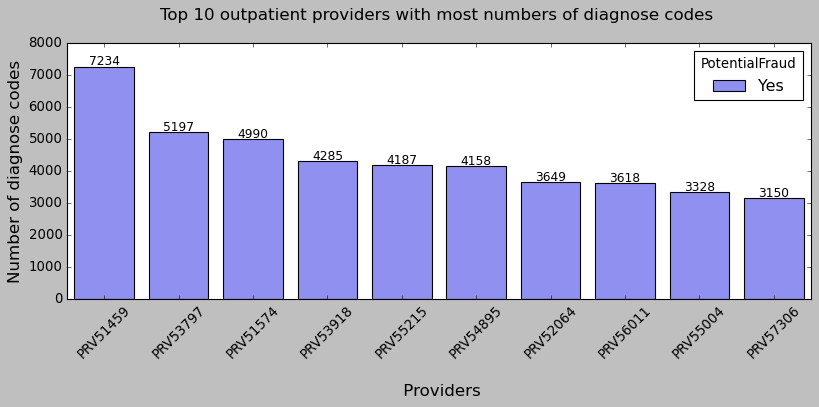

In [61]:
plt.figure(figsize=(12, 4))
top10_outpatient_ndiagcode = provider_ndiagcode[provider_ndiagcode['if_inpatient']==0].head(10)
fig = sns.barplot(data=top10_outpatient_ndiagcode, x='Provider', y='Diag_Code_Cnt', hue='PotentialFraud', palette='cool_r')
# Grouped bar chart with labels
for p in fig.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    fig.annotate('{:.0f}'.format(height), (x+width/2,y+height*1.01), 
                 ha='center', fontsize=11)
# fig.bar_label(fig.containers[0], size=12) # bar chart with labels
plt.xticks(rotation=45)   
plt.xlabel("\n Providers", fontsize = 15)
plt.ylabel("Number of diagnose codes", fontsize = 15)
plt.title("Top 10 outpatient providers with most numbers of diagnose codes \n", fontsize = 15)
plt.show()

### Observe the number of clmadmitdiagnosis codes submitted by inpatient and oupatient providers, and compare potiential fraud and non-fraud transcations.

<Figure size 1440x400 with 0 Axes>

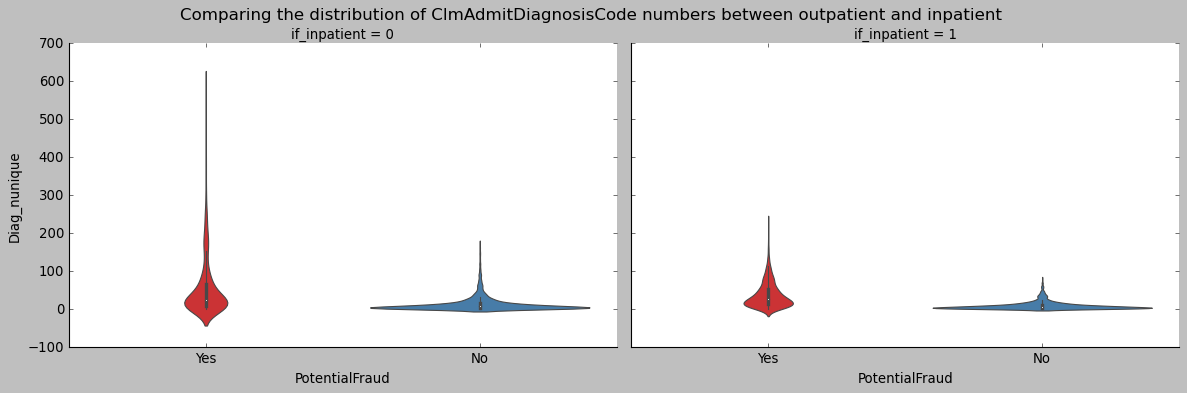

In [62]:
plt.figure(figsize = (18,5))
cat = sns.catplot(x="PotentialFraud", y="Diag_nunique", col="if_inpatient", data=provider_group_integrated, palette="Set1",
                order=['Yes','No'], height=5, aspect=1.5,  kind="violin")
cat.fig.subplots_adjust(top=0.89)
cat.fig.suptitle("Comparing the distribution of ClmAdmitDiagnosisCode numbers between outpatient and inpatient \n", fontsize = 15)
plt.show()

In [63]:
provider_ndiag=provider_group_integrated[['Provider','if_inpatient','Diag_nunique','PotentialFraud']].sort_values(by='Diag_nunique',ascending=False)
provider_ndiag.head()

Provider  if_inpatient  Diag_nunique PotentialFraud
536   PRV51459             0           583            Yes
3023  PRV53797             0           402            Yes
683   PRV51574             0           400            Yes
3127  PRV53918             0           360            Yes
4133  PRV54895             0           358            Yes

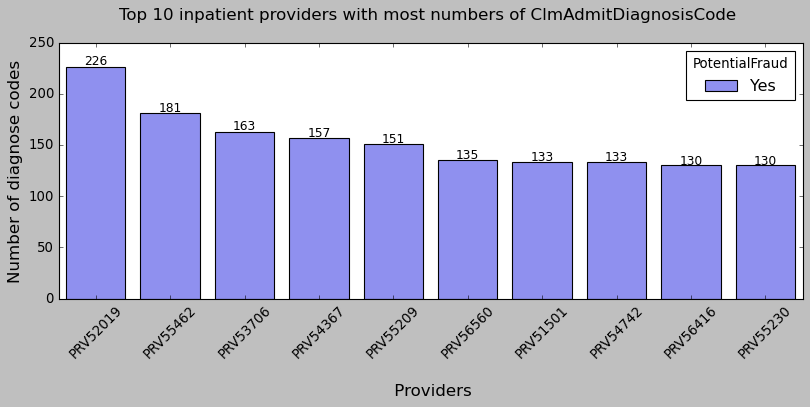

In [64]:
plt.figure(figsize=(12, 4))
top10_inpatient_ndiag = provider_ndiag[provider_ndiag['if_inpatient']==1].head(10)
fig = sns.barplot(data=top10_inpatient_ndiag, x='Provider', y='Diag_nunique', hue='PotentialFraud', palette='cool_r')
# Grouped bar chart with labels
for p in fig.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    fig.annotate('{:.0f}'.format(height), (x+width/2,y+height*1.01), 
                 ha='center', fontsize=11)
# fig.bar_label(fig.containers[0], size=12) # bar chart with labels
plt.xticks(rotation=45)   
plt.xlabel("\n Providers", fontsize = 15)
plt.ylabel("Number of diagnose codes", fontsize = 15)
plt.title("Top 10 inpatient providers with most numbers of ClmAdmitDiagnosisCode \n", fontsize = 15)
plt.show()

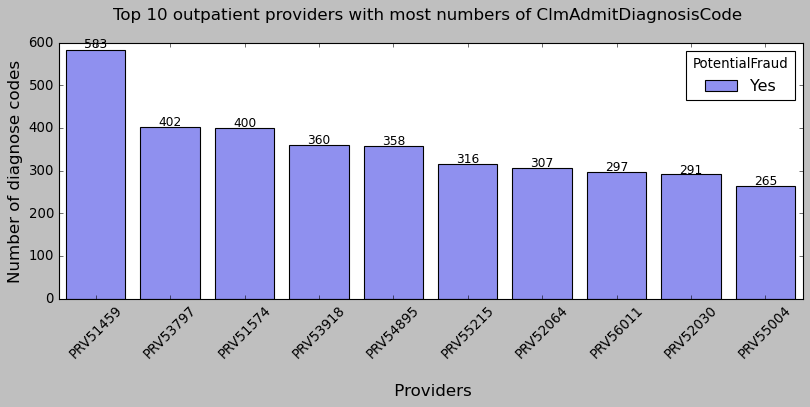

In [65]:
plt.figure(figsize=(12, 4))
top10_outpatient_ndiag = provider_ndiag[provider_ndiag['if_inpatient']==0].head(10)
fig = sns.barplot(data=top10_outpatient_ndiag, x='Provider', y='Diag_nunique', hue='PotentialFraud', palette='cool_r')
# Grouped bar chart with labels
for p in fig.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    fig.annotate('{:.0f}'.format(height), (x+width/2,y+height*1.01), 
                 ha='center', fontsize=11)
# fig.bar_label(fig.containers[0], size=12) # bar chart with labels
plt.xticks(rotation=45)   
plt.xlabel("\n Providers", fontsize = 15)
plt.ylabel("Number of diagnose codes", fontsize = 15)
plt.title("Top 10 outpatient providers with most numbers of ClmAdmitDiagnosisCode \n", fontsize = 15)
plt.show()

<Figure size 1440x400 with 0 Axes>

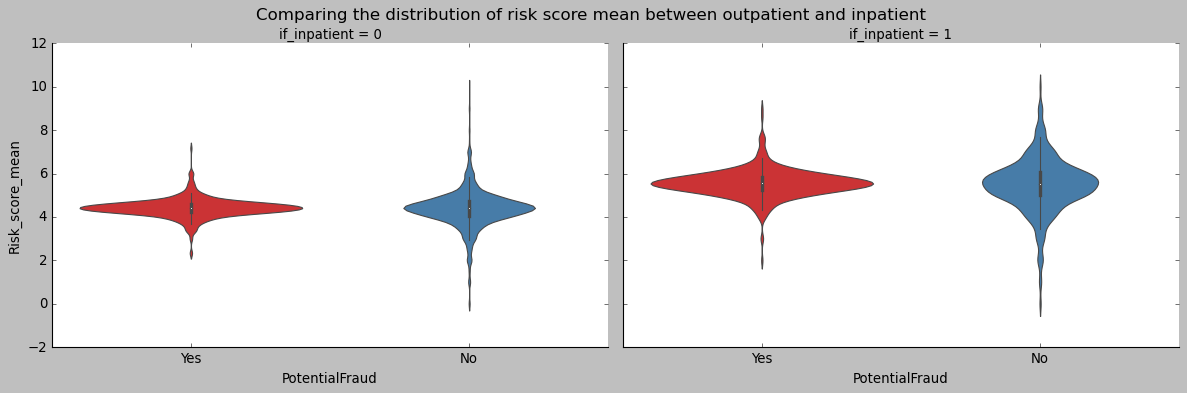

In [66]:
plt.figure(figsize = (18,5))
cat = sns.catplot(x="PotentialFraud", y="Risk_score_mean", col="if_inpatient", data=provider_group_integrated, palette="Set1",
                order=['Yes','No'], height=5, aspect=1.5,  kind="violin")
cat.fig.subplots_adjust(top=0.89)
cat.fig.suptitle("Comparing the distribution of risk score mean between outpatient and inpatient \n", fontsize = 15)
plt.show()

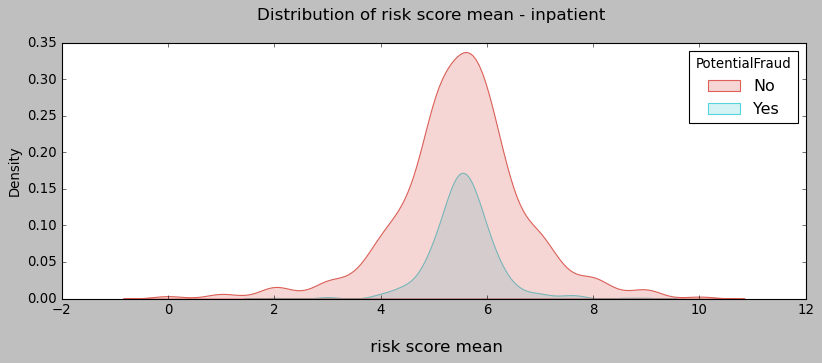

In [67]:
plt.figure(figsize=(12, 4))
sns.kdeplot(data=provider_group_integrated[provider_group_integrated['if_inpatient']==1], x='Risk_score_mean', hue="PotentialFraud", fill=True,  palette='hls')
#sns.histplot(data=provider_group_integrated[provider_group_integrated['if_inpatient']==1], x='Claim_nunique',kde=True, hue='PotentialFraud') 
plt.title("Distribution of risk score mean - inpatient \n",fontsize = 15)
plt.xlabel("\n risk score mean", fontsize = 15)
plt.show()

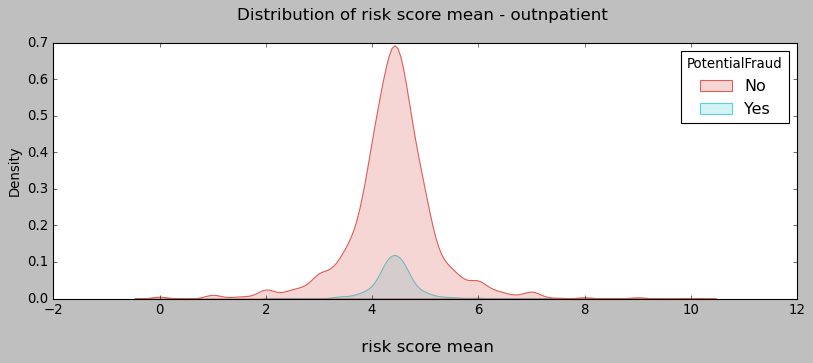

In [68]:
plt.figure(figsize=(12, 4))
sns.kdeplot(data=provider_group_integrated[provider_group_integrated['if_inpatient']==0], x='Risk_score_mean', hue="PotentialFraud", fill=True,  palette='hls')
#sns.histplot(data=provider_group_integrated[provider_group_integrated['if_inpatient']==1], x='Claim_nunique',kde=True, hue='PotentialFraud') 
plt.title("Distribution of risk score mean - outnpatient \n",fontsize = 15)
plt.xlabel("\n risk score mean", fontsize = 15)
plt.show()

In [69]:
provider_risk_mean=provider_group_integrated[['Provider','if_inpatient','Risk_score_mean','PotentialFraud']].sort_values(by='Risk_score_mean',ascending=False)
provider_risk_mean.head()

Provider  if_inpatient  Risk_score_mean PotentialFraud
5157  PRV55881             0             10.0             No
3268  PRV54054             1             10.0             No
730   PRV51607             1             10.0             No
2552  PRV53329             1             10.0             No
2446  PRV53240             1             10.0             No

<Figure size 800x800 with 0 Axes>

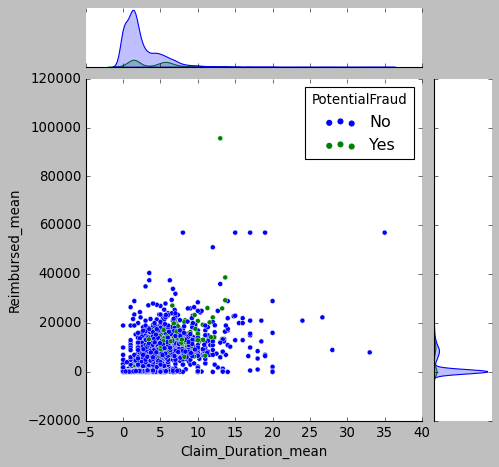

<Figure size 800x800 with 0 Axes>

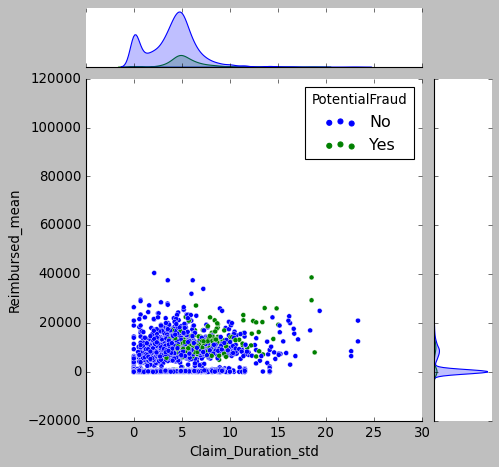

<Figure size 800x800 with 0 Axes>

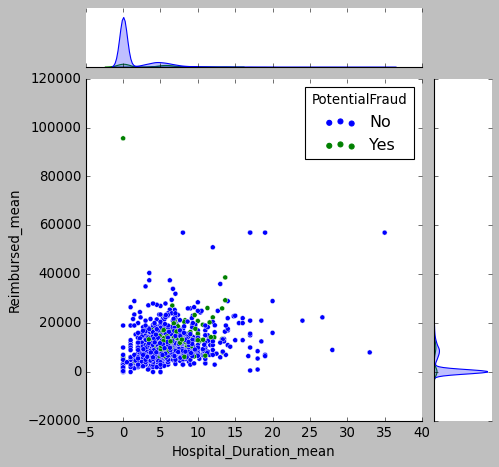

<Figure size 800x800 with 0 Axes>

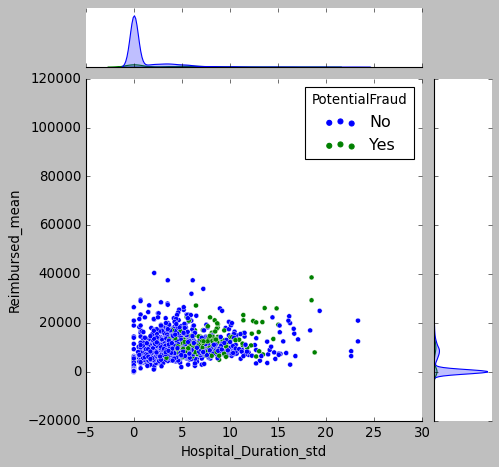

<Figure size 800x800 with 0 Axes>

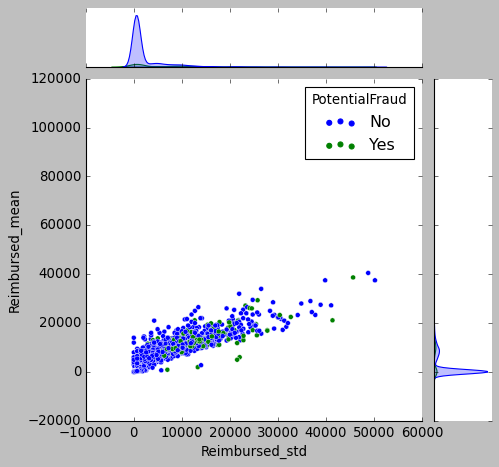

<Figure size 800x800 with 0 Axes>

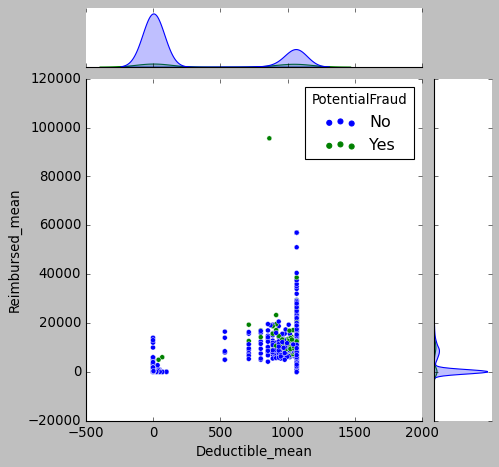

<Figure size 800x800 with 0 Axes>

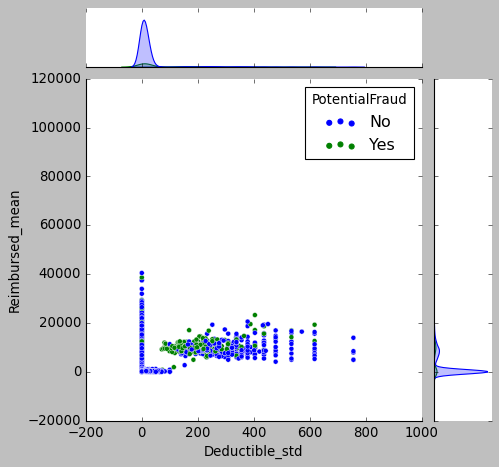

<Figure size 800x800 with 0 Axes>

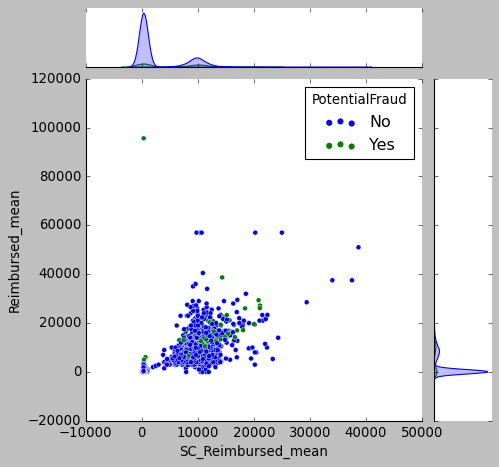

<Figure size 800x800 with 0 Axes>

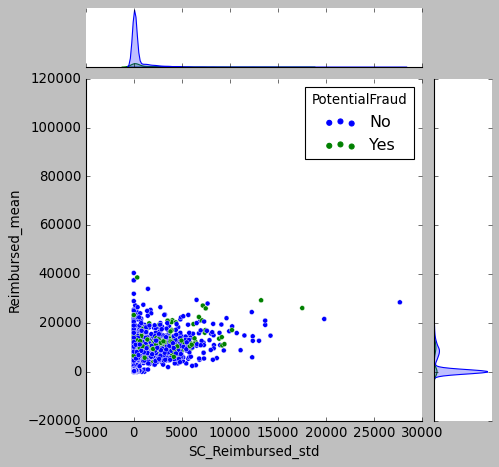

<Figure size 800x800 with 0 Axes>

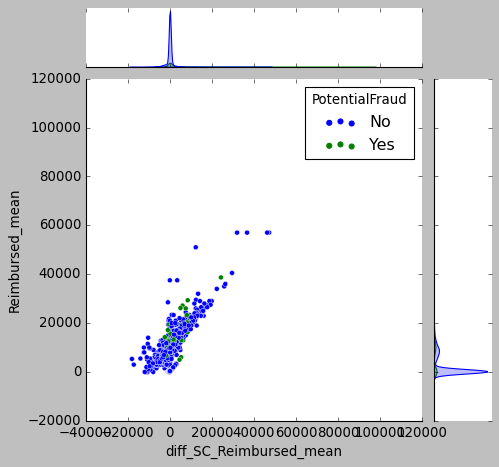

<Figure size 800x800 with 0 Axes>

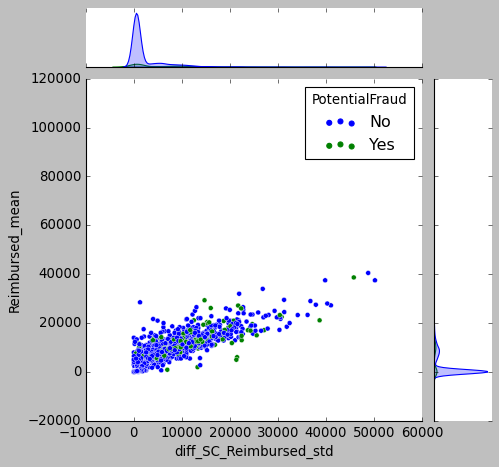

<Figure size 800x800 with 0 Axes>

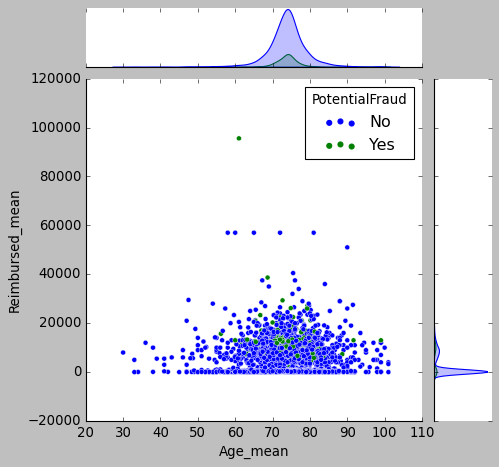

<Figure size 800x800 with 0 Axes>

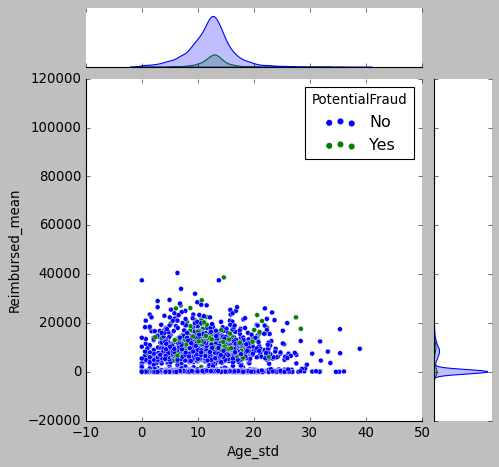

<Figure size 800x800 with 0 Axes>

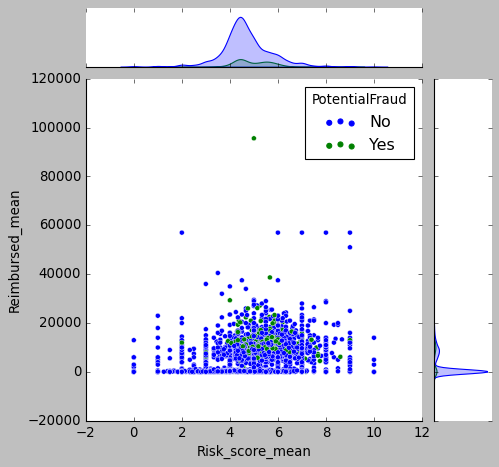

<Figure size 800x800 with 0 Axes>

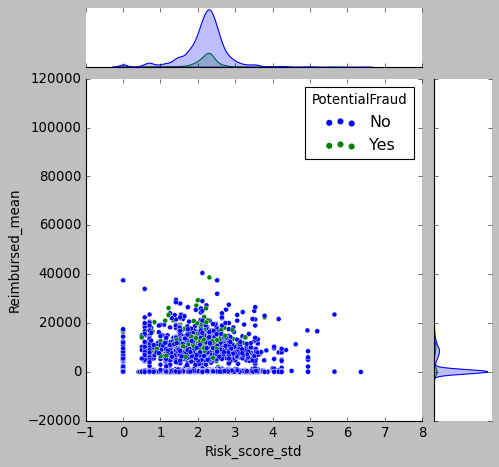

<Figure size 800x800 with 0 Axes>

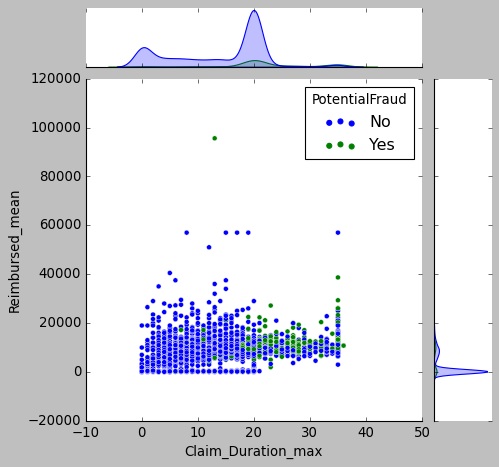

<Figure size 800x800 with 0 Axes>

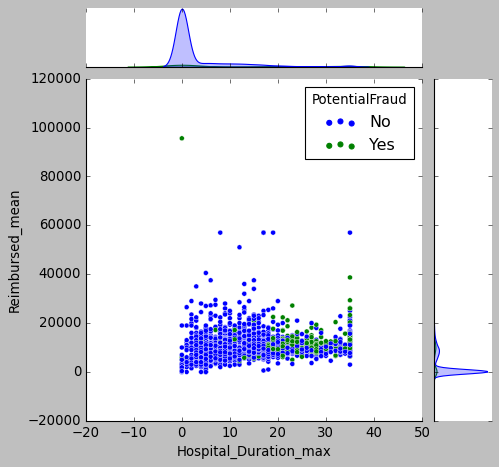

<Figure size 800x800 with 0 Axes>

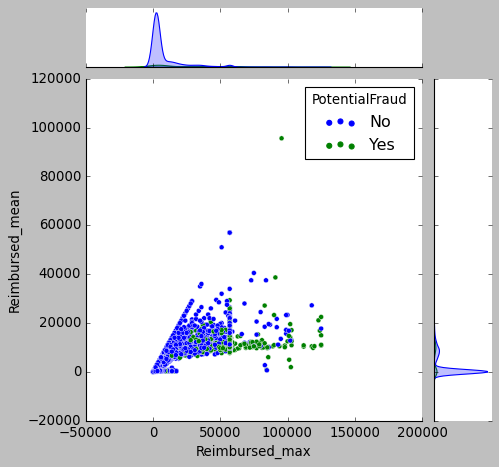

<Figure size 800x800 with 0 Axes>

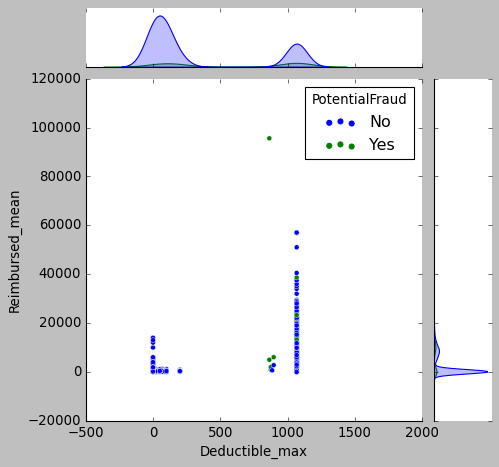

<Figure size 800x800 with 0 Axes>

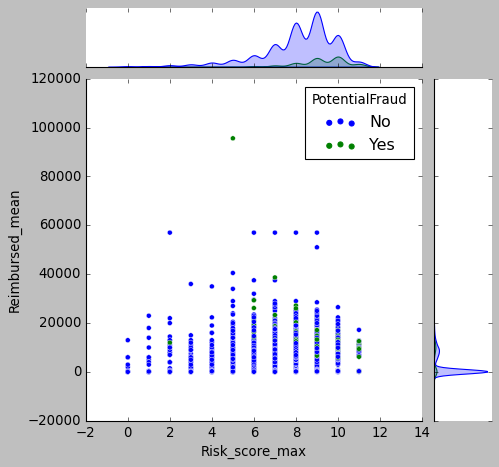

<Figure size 800x800 with 0 Axes>

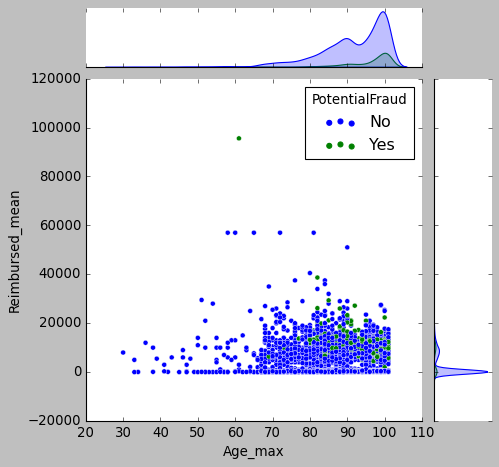

In [70]:
col_list = ['Claim_Duration_mean','Claim_Duration_std','Hospital_Duration_mean','Hospital_Duration_std',
                            'Reimbursed_std','Deductible_mean','Deductible_std',
                            'SC_Reimbursed_mean','SC_Reimbursed_std','diff_SC_Reimbursed_mean','diff_SC_Reimbursed_std',
                            'Age_mean','Age_std','Risk_score_mean','Risk_score_std',
                            'Claim_Duration_max','Hospital_Duration_max','Reimbursed_max','Deductible_max','Risk_score_max','Age_max']

y = 'Reimbursed_mean'

hue = 'PotentialFraud'

for col in col_list:
    plt.figure(figsize=(10, 10))
    x = provider_group_integrated[col]
    sns.jointplot(x=x, y=y, hue=hue, data=provider_group_integrated)

<Figure size 800x800 with 0 Axes>

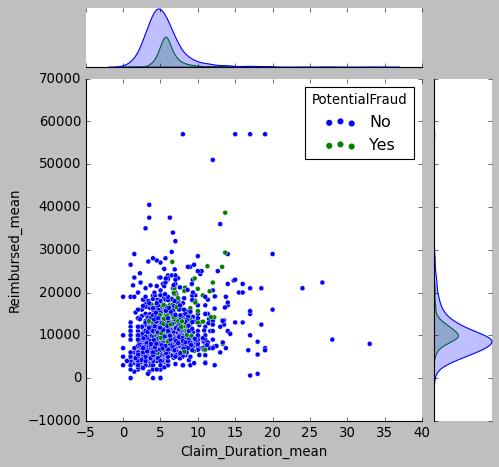

<Figure size 800x800 with 0 Axes>

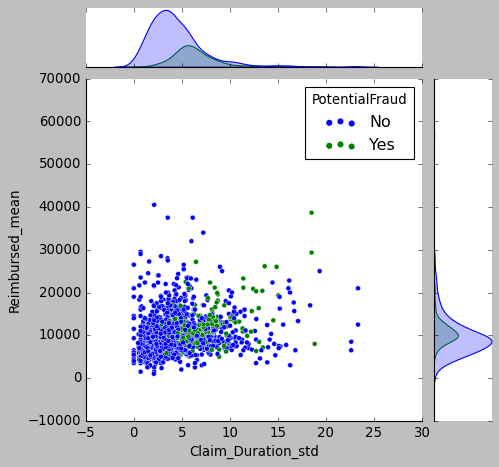

<Figure size 800x800 with 0 Axes>

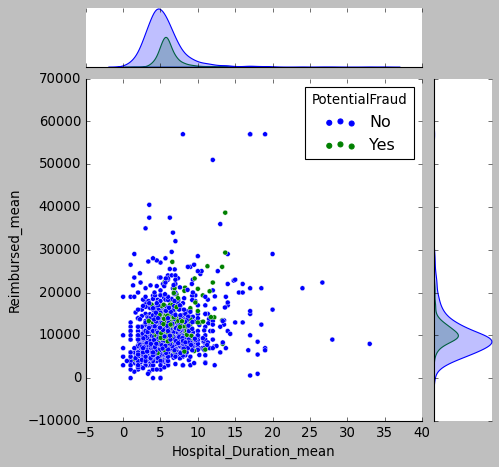

<Figure size 800x800 with 0 Axes>

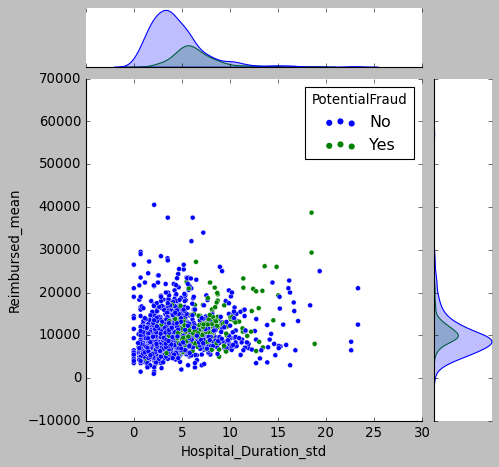

<Figure size 800x800 with 0 Axes>

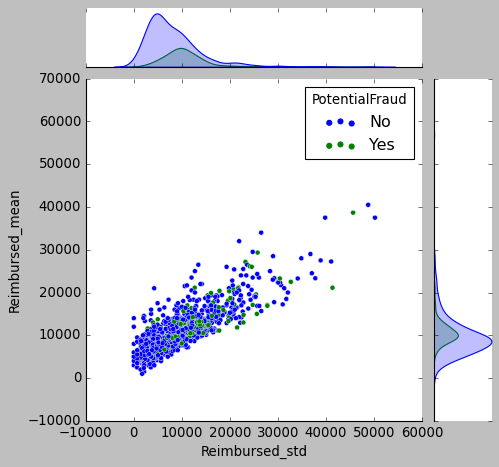

<Figure size 800x800 with 0 Axes>

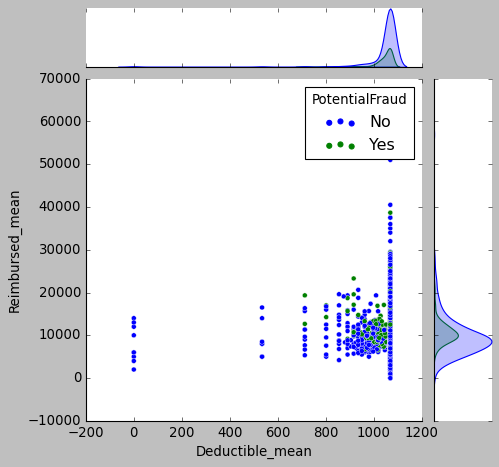

<Figure size 800x800 with 0 Axes>

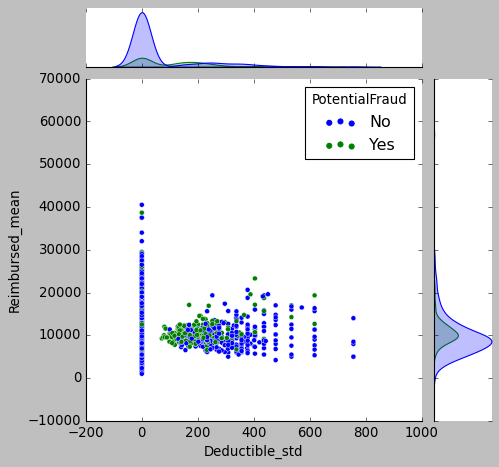

<Figure size 800x800 with 0 Axes>

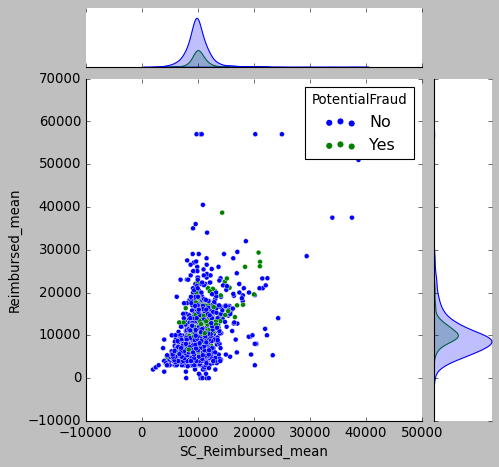

<Figure size 800x800 with 0 Axes>

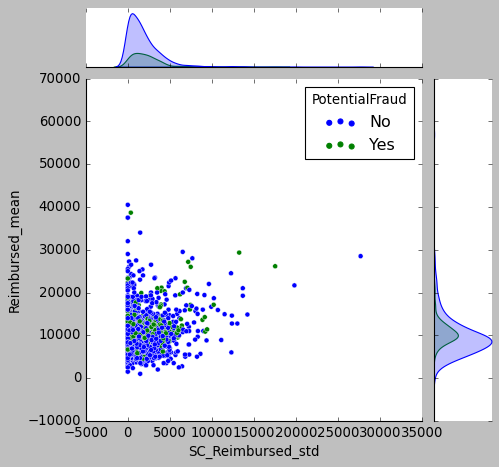

<Figure size 800x800 with 0 Axes>

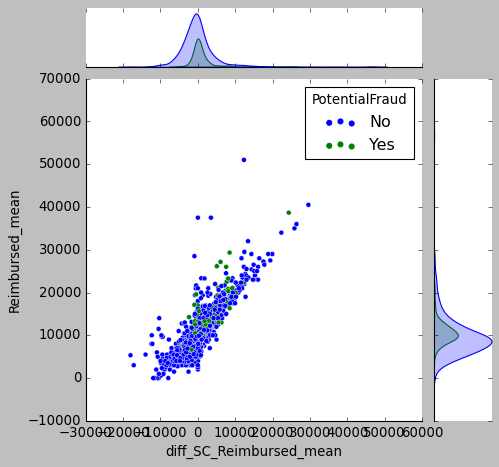

<Figure size 800x800 with 0 Axes>

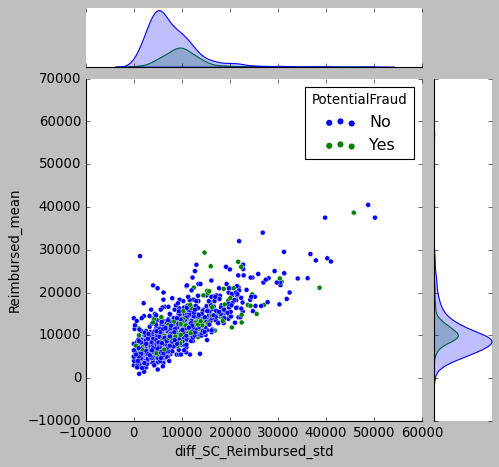

<Figure size 800x800 with 0 Axes>

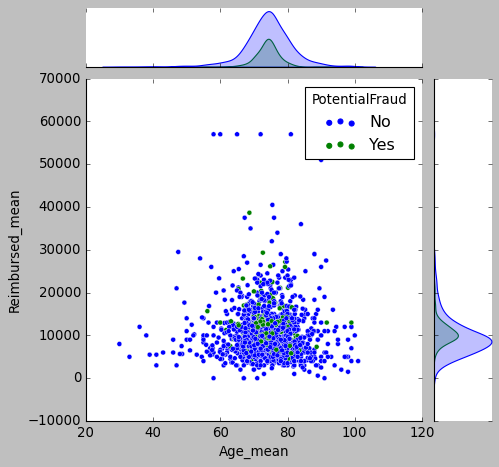

<Figure size 800x800 with 0 Axes>

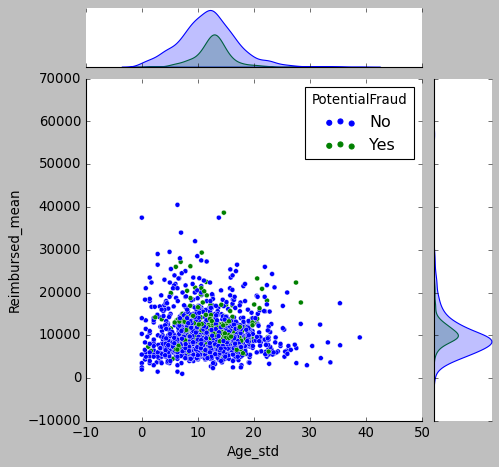

<Figure size 800x800 with 0 Axes>

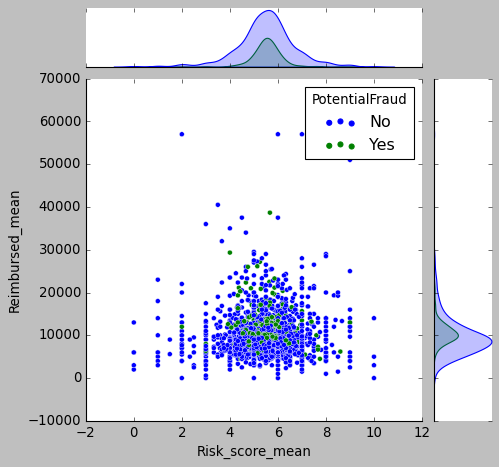

<Figure size 800x800 with 0 Axes>

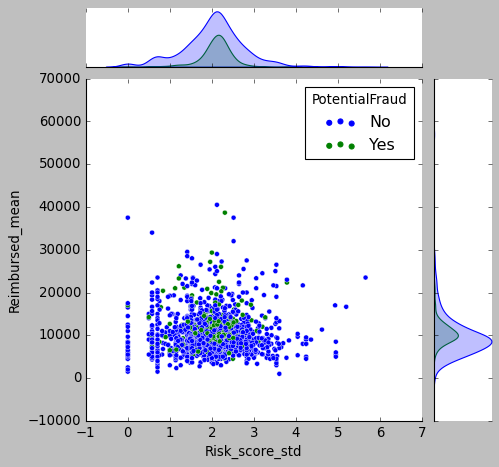

<Figure size 800x800 with 0 Axes>

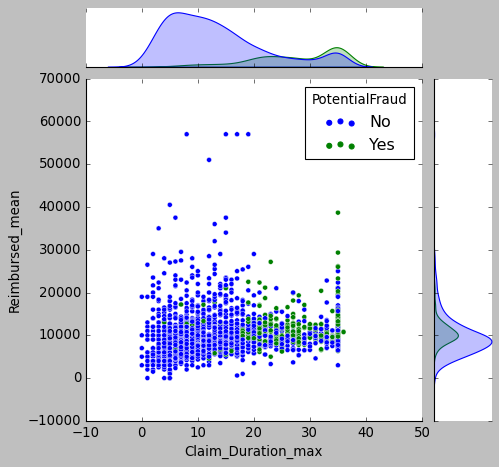

<Figure size 800x800 with 0 Axes>

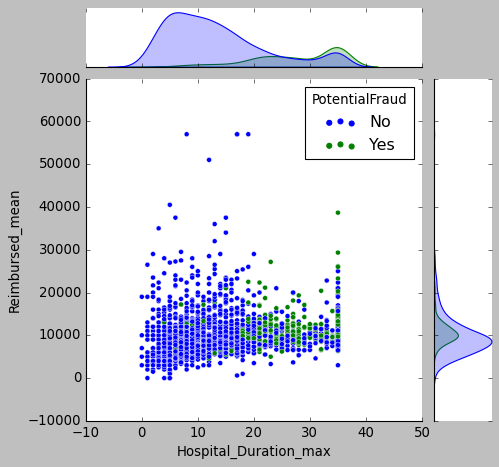

<Figure size 800x800 with 0 Axes>

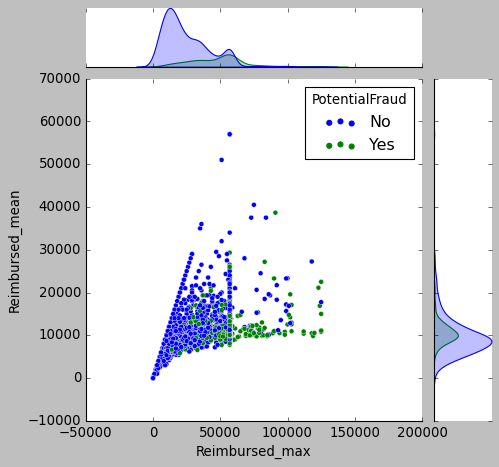

<Figure size 800x800 with 0 Axes>

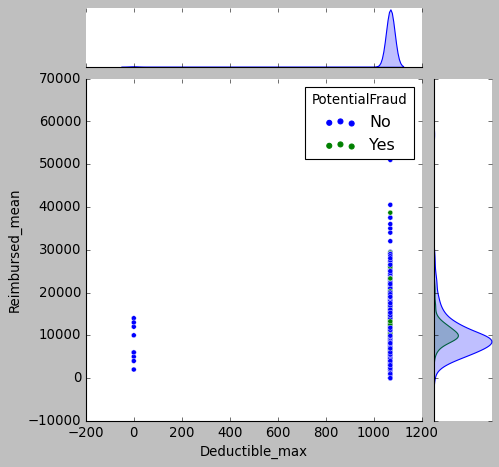

<Figure size 800x800 with 0 Axes>

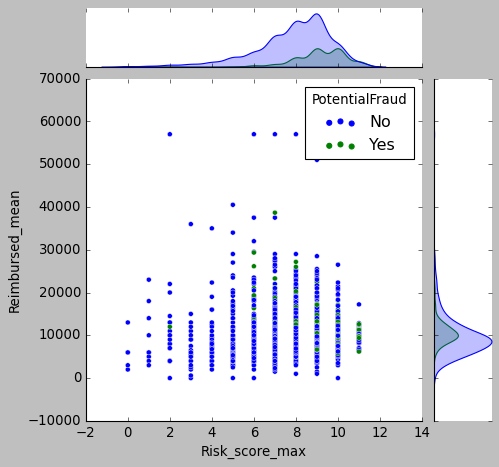

<Figure size 800x800 with 0 Axes>

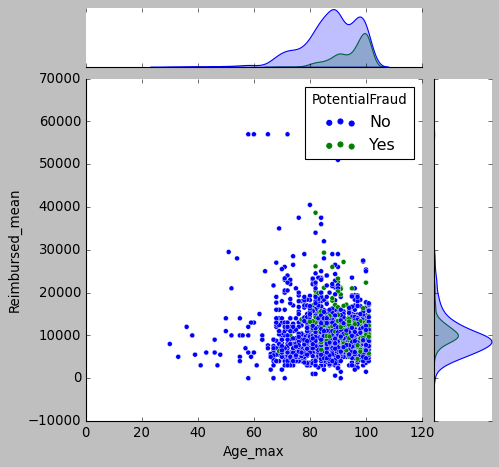

In [71]:
df_in = provider_group_integrated[provider_group_integrated['if_inpatient']==1]

for col in col_list:
    plt.figure(figsize=(10, 10))
    x = df_in[col]
    sns.jointplot(x=x, y=y, hue=hue, data=df_in)

In [72]:
provider_group_integrated.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7104 entries, 0 to 7103
Data columns (total 48 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Provider                 7104 non-null   object 
 1   if_inpatient             7104 non-null   int64  
 2   Bene_nunique             7104 non-null   int64  
 3   Claim_nunique            7104 non-null   int64  
 4   Att_nunique              7104 non-null   int64  
 5   Op_nunique               7104 non-null   int64  
 6   Othr_nunique             7104 non-null   int64  
 7   Diag_nunique             7104 non-null   int64  
 8   CD1                      7104 non-null   int64  
 9   CD2                      7104 non-null   int64  
 10  CD3                      7104 non-null   int64  
 11  CD4                      7104 non-null   int64  
 12  CD5                      7104 non-null   int64  
 13  CD6                      7104 non-null   int64  
 14  CD7                     

In [73]:
provider_group_integrated = provider_group_integrated.fillna(0)

In [74]:
df = provider_group_integrated
df.to_csv('Data/df.csv', index= False)
df.head(5)

Provider  if_inpatient  Bene_nunique  Claim_nunique  Att_nunique  \
0  PRV51001             0            19             20           10   
1  PRV51001             1             5              5            4   
2  PRV51003             0            66             70           44   
3  PRV51003             1            53             62            2   
4  PRV51004             0           138            149           38   

   Op_nunique  Othr_nunique  Diag_nunique  CD1  CD2  CD3  CD4  CD5  CD6  CD7  \
0           4             8             7   19   12    6    4    4    4    1   
1           3             2             5    5    5    5    5    5    5    4   
2           6            23            16   66   42   23   16    9    4    4   
3           3             1            46   52   53   49   48   50   45   46   
4          20            27            26  129   69   53   33   22   13    9   

   CD8  CD9  CD10  CP1  CP2  CP3  Claim_Duration_mean  Claim_Duration_std  \
0    1    1     1    1    1    1             0.550000            2.012461   
1    3    2     1    3    2    1             5.000000            5.385165   
2    4    2     2    1    1    1             2.357143            6.043408   
3   40   38     5   33    8    1             5.161290            4.447116   
4    8    5     1    1    1    1             1.429530            4.783495   

   Hospital_Duration_mean  Hospital_Duration_std  Reimbursed_mean  \
0                 0.00000               0.000000       382.000000   
1                 5.00000               5.385165     19400.000000   
2                 0.00000               0.000000       466.714286   
3                 5.16129               4.447116      9241.935484   
4                 0.00000               0.000000       350.134228   

   Reimbursed_std  Deductible_mean  Deductible_std  SC_Reimbursed_mean  \
0      422.817617         0.000000        0.000000          299.702500   
1    18352.111595      1068.000000        0.000000        20165.546000   
2      821.364579         1.000000        8.366600          314.848143   
3     8513.606244      1068.000000        0.000000         8701.691290   
4      689.963754         2.080537       11.166744          279.555503   

   SC_Reimbursed_std  diff_SC_Reimbursed_mean  diff_SC_Reimbursed_std  \
0          30.794253                82.297500              419.930347   
1        9116.820061              -765.546000            20532.435414   
2          90.956632               151.866143              799.878171   
3        3576.680087               540.244194             7430.875589   
4          47.468938                70.578725              687.620251   

    Age_mean    Age_std  Risk_score_mean  Risk_score_std  Claim_Duration_max  \
0  78.950000  12.584347         5.450000        1.637553                   9   
1  78.400000  10.644247         6.000000        3.240370                  14   
2  69.314286  12.600371         4.214286        2.219106                  20   
3  70.822581  14.329294         4.919355        2.278182                  27   
4  72.161074  12.955259         4.342282        2.429469                  20   

   Hospital_Duration_max  Reimbursed_max  Deductible_max  Risk_score_max  \
0                    0.0            1500             0.0               9   
1                   14.0           42000          1068.0              10   
2                    0.0            3300            70.0              10   
3                   27.0           57000          1068.0              10   
4                    0.0            3300           100.0               9   

   Age_max  Physician_Cnt  Diag_Code_Cnt  Proc_Code_Cnt  \
0       98             22             53              3   
1       96              9             40              6   
2       97             73            172              3   
3       94              6            426             42   
4      100             85            342              3   

   Insurance_Covered_Per PotentialFraud 

In [75]:
df_groupby_provider1 = provider_group_integrated.drop(['Provider'], axis=1)
df_groupby_provider1.to_csv('Data/df_groupby_provider1.csv', index= False)
df_groupby_provider1.head(2)

if_inpatient  Bene_nunique  Claim_nunique  Att_nunique  Op_nunique  \
0             0            19             20           10           4   
1             1             5              5            4           3   

   Othr_nunique  Diag_nunique  CD1  CD2  CD3  CD4  CD5  CD6  CD7  CD8  CD9  \
0             8             7   19   12    6    4    4    4    1    1    1   
1             2             5    5    5    5    5    5    5    4    3    2   

   CD10  CP1  CP2  CP3  Claim_Duration_mean  Claim_Duration_std  \
0     1    1    1    1                 0.55            2.012461   
1     1    3    2    1                 5.00            5.385165   

   Hospital_Duration_mean  Hospital_Duration_std  Reimbursed_mean  \
0                     0.0               0.000000            382.0   
1                     5.0               5.385165          19400.0   

   Reimbursed_std  Deductible_mean  Deductible_std  SC_Reimbursed_mean  \
0      422.817617              0.0             0.0            299.7025   
1    18352.111595           1068.0             0.0          20165.5460   

   SC_Reimbursed_std  diff_SC_Reimbursed_mean  diff_SC_Reimbursed_std  \
0          30.794253                  82.2975              419.930347   
1        9116.820061                -765.5460            20532.435414   

   Age_mean    Age_std  Risk_score_mean  Risk_score_std  Claim_Duration_max  \
0     78.95  12.584347             5.45        1.637553                   9   
1     78.40  10.644247             6.00        3.240370                  14   

   Hospital_Duration_max  Reimbursed_max  Deductible_max  Risk_score_max  \
0                    0.0            1500             0.0               9   
1                   14.0           42000          1068.0              10   

   Age_max  Physician_Cnt  Diag_Code_Cnt  Proc_Code_Cnt  \
0       98             22             53              3   
1       96              9             40              6   

   Insurance_Covered_Per PotentialFraud  
0                 100.00             No  
1                  94.78             No

In [76]:
df_groupby_provider2 = provider_group_integrated.drop(['Provider','Att_nunique','Op_nunique','Othr_nunique','CD1','CD2','CD3',
                                                'CD4','CD5','CD6','CD7','CD8','CD9','CD10','CP1','CP2','CP3'], axis=1)
df_groupby_provider2.to_csv('Data/df_groupby_provider2.csv', index= False)
df_groupby_provider2.head(2)

if_inpatient  Bene_nunique  Claim_nunique  Diag_nunique  \
0             0            19             20             7   
1             1             5              5             5   

   Claim_Duration_mean  Claim_Duration_std  Hospital_Duration_mean  \
0                 0.55            2.012461                     0.0   
1                 5.00            5.385165                     5.0   

   Hospital_Duration_std  Reimbursed_mean  Reimbursed_std  Deductible_mean  \
0               0.000000            382.0      422.817617              0.0   
1               5.385165          19400.0    18352.111595           1068.0   

   Deductible_std  SC_Reimbursed_mean  SC_Reimbursed_std  \
0             0.0            299.7025          30.794253   
1             0.0          20165.5460        9116.820061   

   diff_SC_Reimbursed_mean  diff_SC_Reimbursed_std  Age_mean    Age_std  \
0                  82.2975              419.930347     78.95  12.584347   
1                -765.5460            20532.435414     78.40  10.644247   

   Risk_score_mean  Risk_score_std  Claim_Duration_max  Hospital_Duration_max  \
0             5.45        1.637553                   9                    0.0   
1             6.00        3.240370                  14                   14.0   

   Reimbursed_max  Deductible_max  Risk_score_max  Age_max  Physician_Cnt  \
0            1500             0.0               9       98             22   
1           42000          1068.0              10       96              9   

   Diag_Code_Cnt  Proc_Code_Cnt  Insurance_Covered_Per PotentialFraud  
0             53              3                 100.00             No  
1             40              6                  94.78             No